In [1]:
import gammapy
print(gammapy.__version__ , " == 1")

0.1.dev19174+g56b5bdf  == 1


In [2]:
import numpy as np
import os
import astropy
from astropy import units as u
from collections import OrderedDict
from astropy import units
from gammapy.data import DataStore
from astropy.io import fits
from astropy.coordinates import SkyCoord
from gammapy.data import FixedPointingInfo, Observation, DataStore
from astropy.coordinates import SkyOffsetFrame
from gammapy.maps import WcsNDMap, WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMakerprojection
from gammapy.datasets import MapDataset
from gammapy.irf import load_cta_irfs, EDispKernel, PSFKernel
from gammapy.modeling import Fit

from gammapy.modeling.models import (
    Models,
    FoVBackgroundModel,
)
from regions import CircleSkyRegion, RectangleSkyRegion


In [3]:
# define some functions for the geometry
def get_ebins():
    min_energy = 0
    ebins = np.logspace(-1,2,25)
    e_edges = ebins.copy()[np.where(ebins>=min_energy)[0][0]:]
    return e_edges*u.TeV

def get_geom():    

    geom_set = dict(
            width = (lon_width * u.deg, lat_width * u.deg),
            pix_size = pix_size * u.deg,
            e_edges  = get_ebins(),
            sky_dir = pks_pos,
            frame = 'icrs'
        )

    eaxis = MapAxis.from_edges(geom_set['e_edges'], name='energy', interp='log')

    geom = WcsGeom.create(
        skydir=geom_set['sky_dir'],
        binsz=geom_set['pix_size'],
        width=geom_set['width'],
        frame=geom_set['frame'],
        proj='CAR',
        axes=[eaxis],
    )

    geom_2d = geom.slice_by_idx(dict(energy=1))

    return geom, geom_2d



## Reading and peeking into the Datastore
The data is the HESS public PKS2155 steady runs. 
See info https://www.mpi-hd.mpg.de/HESS/pages/dl3-dr1/hess_dl3_dr1.pdf

In [4]:
source = 'MSH'
if source == "PKS":
    pks = True
    msh = False
if source == "MSH":
    pks = False
    msh = True

if pks:
    path = '/home/wecapstor1/caph/mppi045h/fits_paper_data/std_fullEnclosure/pks2155_flare/out'
if msh:
    path = '/home/wecapstor1/caph/mppi045h/fits_paper_data/std_fullEnclosure/msh1552/out'
    



#copied from /home/wecapstor1/caph/shared/hess/fits/fits_data/fits_paper_data.tar.gz
path_saving = os.getcwd() 
data_store = DataStore.from_dir(path, f'hdu-index-bg-v05-fov-radec.fits.gz', f'obs-index-bg-v05-fov-radec.fits.gz')
hdul = fits.open(f"{path}/obs-index-bg-v05-fov-radec.fits.gz")
try:
    # File with all the obs ids to analyse
    obsid = f'obsid_{source}.txt'
    obsid = np.loadtxt(obsid)
except:
    string = ''
    for o in data_store.obs_ids:
        string += str(o) + '\n'
    print(string)
    with open(f'obsid_{source}.txt', 'w') as f:
        f.write(string)
    obsid = f'obsid_{source}.txt'
    obsid = np.loadtxt(obsid)




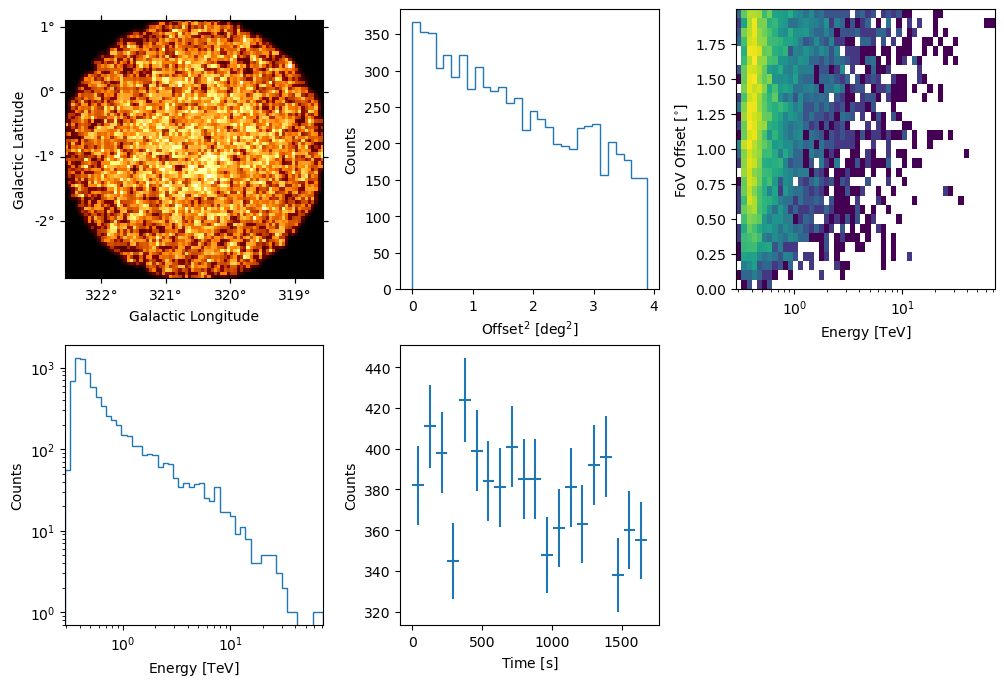

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


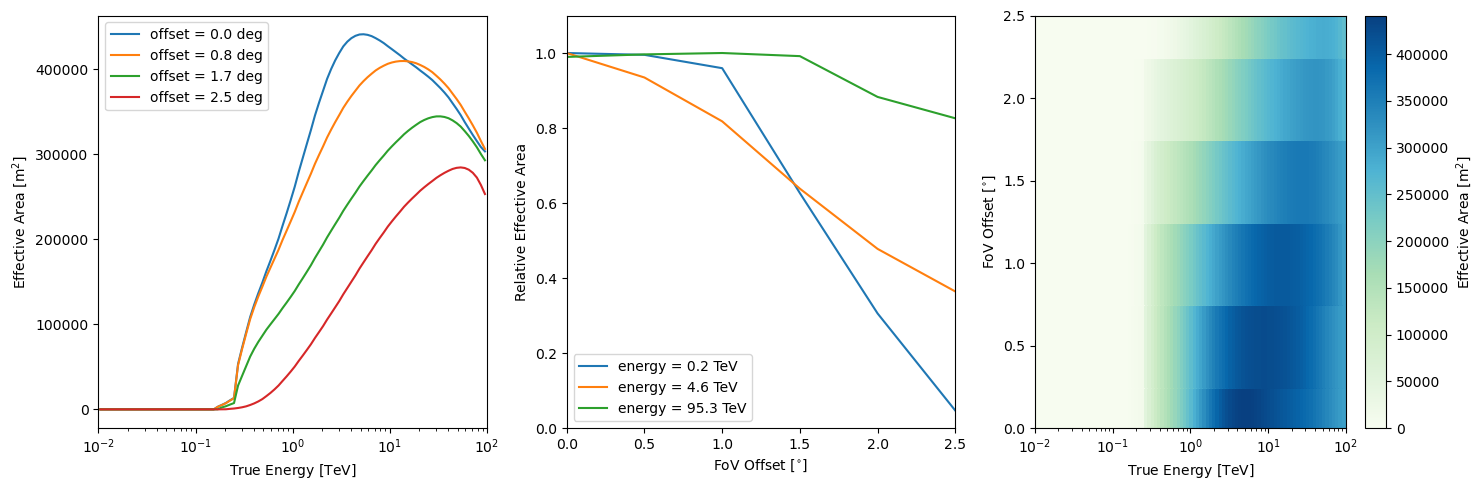

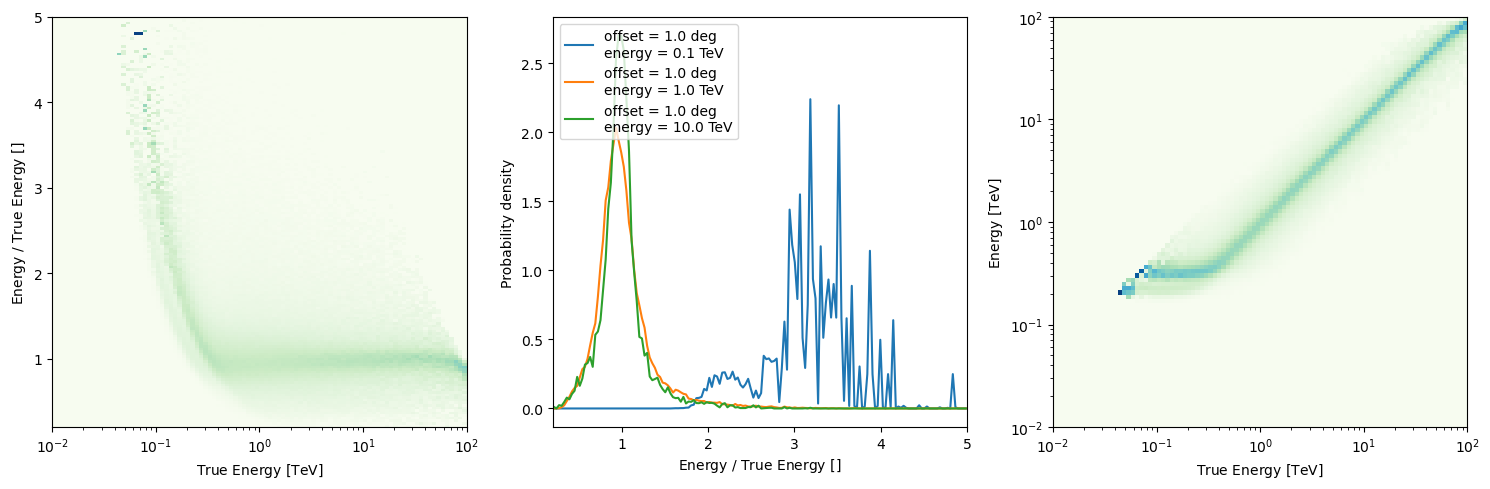

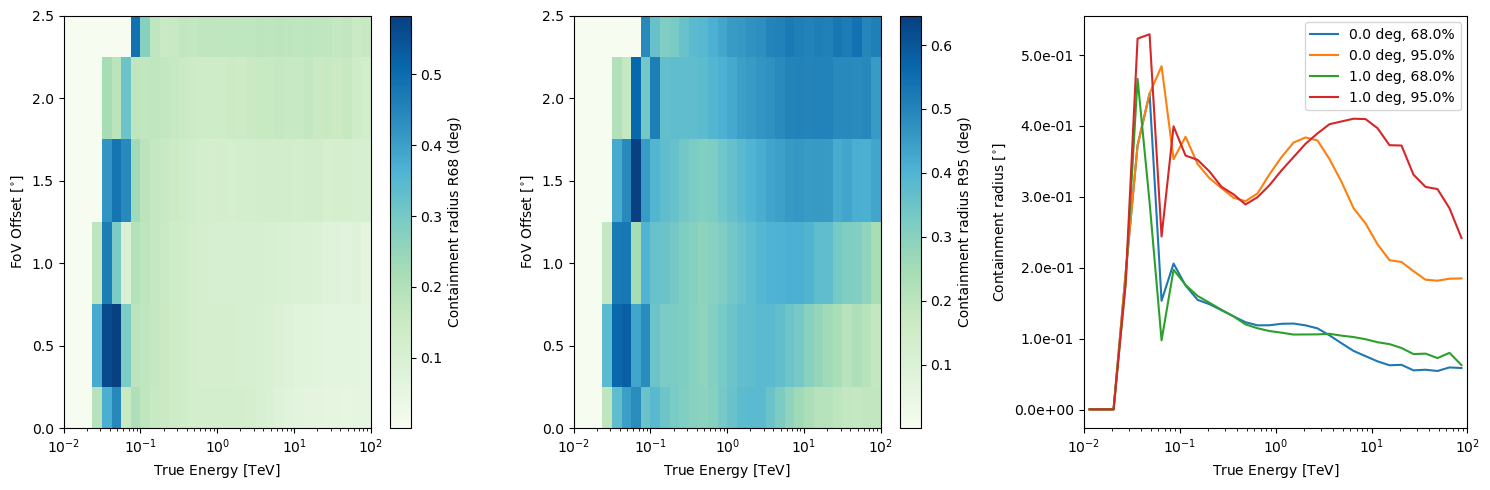

Missing 'HDUCLAS2' keyword assuming 'BKG'


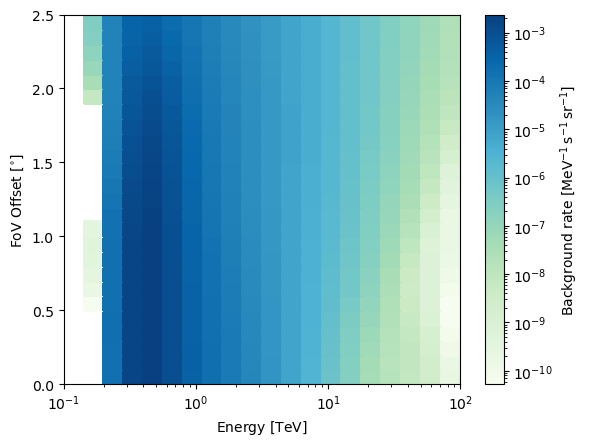

In [5]:
## looking at observation 0 as an example
import matplotlib.pyplot as plt

obs = data_store.obs(obsid[0])
obs.events.select_offset([0, 2] * u.deg).peek()
plt.show()

obs.aeff.peek()
plt.show()

obs.edisp.peek()
plt.show()

obs.psf.peek()
plt.show()

obs.bkg.to_2d().plot()
plt.show()

/home/wecapstor1/caph/mppi045h/gammapy/gammapy/data/observations.py:343: GammapyDeprecationWarning: obs_info property is deprecated since v1.2. Use meta instead.
  warnings.warn(


runs: 20
livetime: 9.13 hr
date: 53090.123451203704-53114.03989796296
avg zenith: 36.9 pm 0.973 deg
duration[max,min]: (28.116666666666692, 15.033333333333339)


Text(0.5, 0, 'Zenith [Deg]')

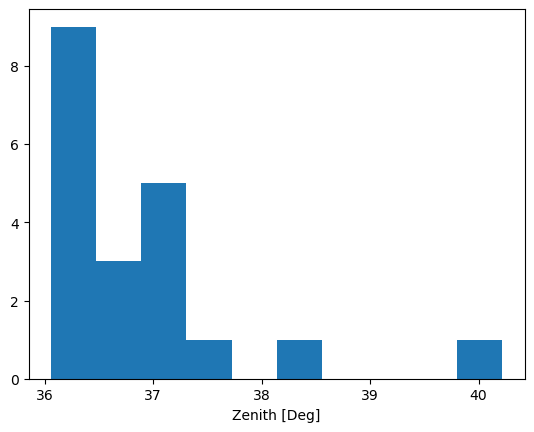

In [6]:
# some info 
ontime=[]
livetime=[]
timeobs=[]
date=[]
angle=[]
observations = data_store.get_observations(obsid)
for obs in observations:
    livetime.append(obs.observation_live_time_duration.value)
    #date.append(obs.obs_info['DATE-OBS'][0:4])
    date.append(obs.tstart)
    #angle.append(obs.obs_info['ZEN_PNT']) info not here anymore
    # compute zenith (0 at top) by 90 - altitude
    angle.append(90-obs.obs_info['ALT_PNT'])

timeobs=np.array(timeobs)
  
print(f'runs: {len(observations)}')
print(f'livetime: {np.sum(livetime)/3600:.3} hr')
print('date:','{}-{}'.format(min(date),max(date)))
print(f'avg zenith: {np.mean(angle):.3} pm {np.std(angle):.3} deg')
print(f'duration[max,min]: {np.max(livetime)/60,np.min(livetime)/60}')
#print('duration:',timeobs/60)
plt.hist(angle)
plt.xlabel('Zenith [Deg]')

In [7]:
# setting the position of the source
if pks:
    pks_pos = SkyCoord("21h58m43.2s", "-30d13m18s")
    pks_pos = SkyCoord(frame = "galactic",l =  "17.74 deg", b= "-52.25 deg")
    print(pks_pos)
if msh:
    #https://www.mpi-hd.mpg.de/HESS/pages/home/sources/
    pks_pos = SkyCoord(frame = "galactic",l =  "320.33 deg", b= "-1.19 deg")
    print(pks_pos)
    

<SkyCoord (Galactic): (l, b) in deg
    (320.33, -1.19)>


## 2. Computing the Energy Threshold
We want to analyse the data only above a certain energy threshold for which we are sure to have reconstructed the data well.

There are two criteria: 
1. The energy bias is smaller than 10 % (stored in ``threshold.txt``)
2. The background rate is smaller than the peak value. (stored in ``bkgthreshold.txt``)

In the end we will use the maximum value of those. 



### 2.1. Energy Bias < 10 % Threshold

In [8]:
# define txt files in which the two different thresholds are written into

store_threshold = f'threshold_{source}.txt'
store_bgthreshold = f'bkg_threshold_{source}.txt'

config = 'std_ImPACT_fullEnclosure'
max_offset = 2.0 
min_energy = 0
ebins = get_ebins()
energy_binning = ebins.copy()[np.where(ebins>=min_energy)[0][0]:] #ebins.copy()[np.where(ebins>=min_energy)[0][0]-1:]





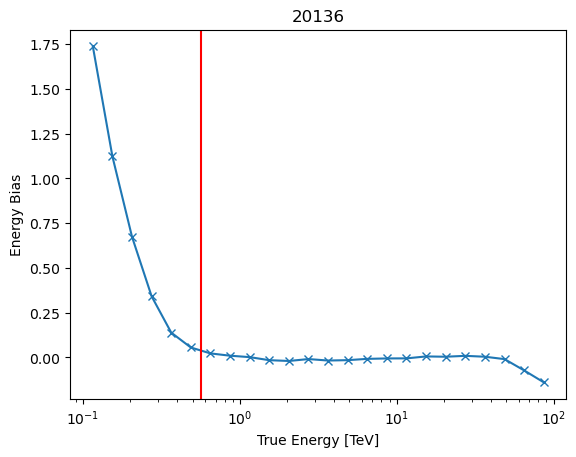

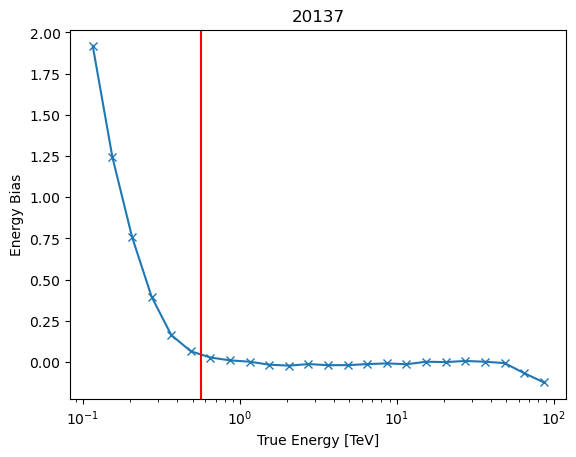

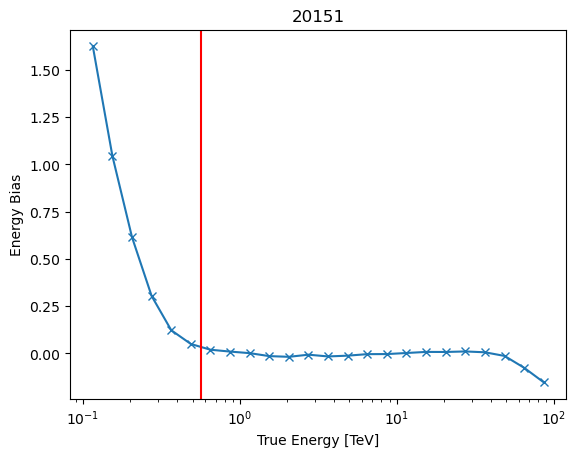

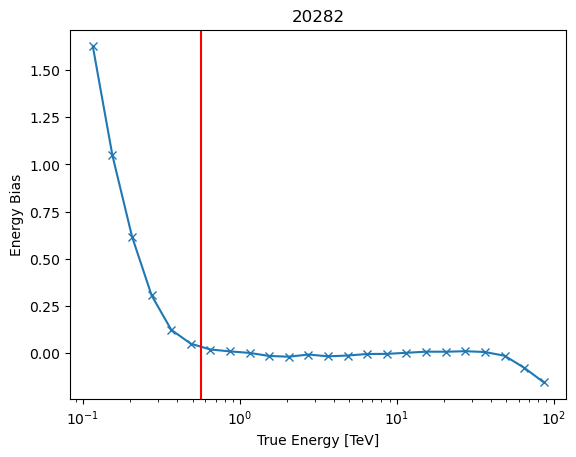

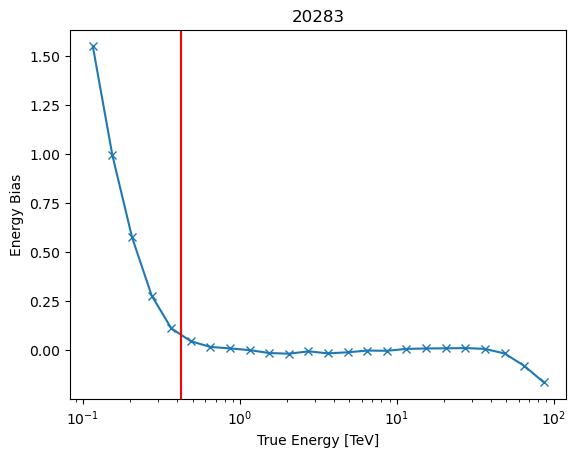

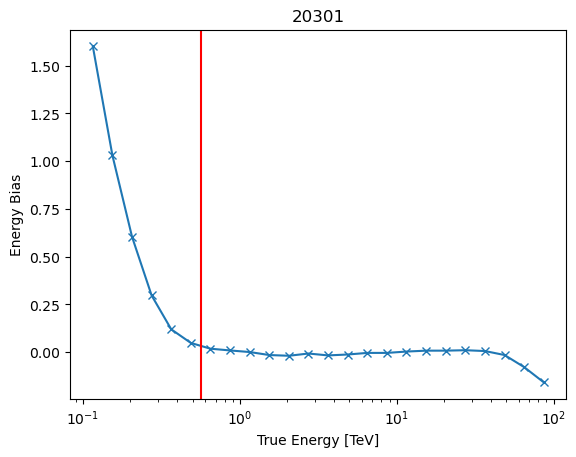

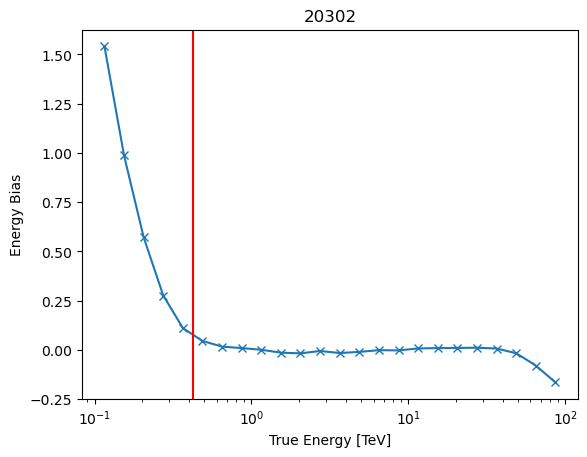

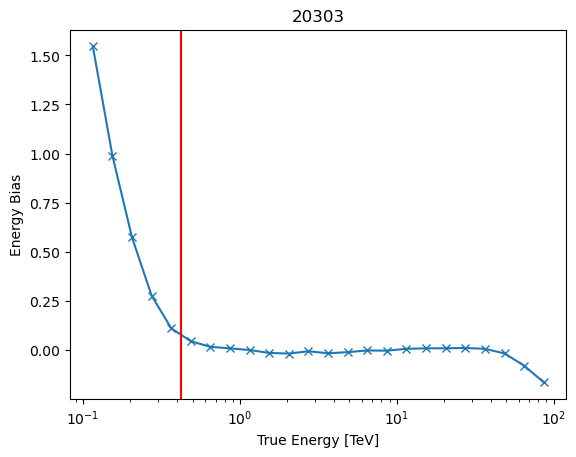

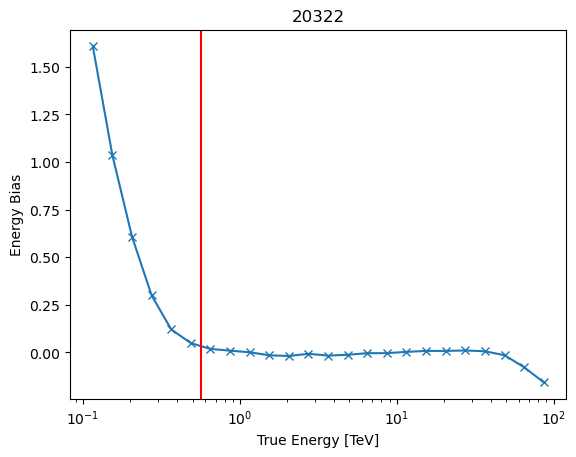

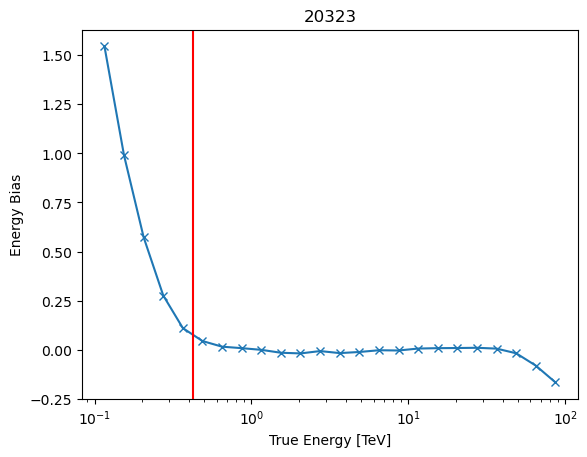

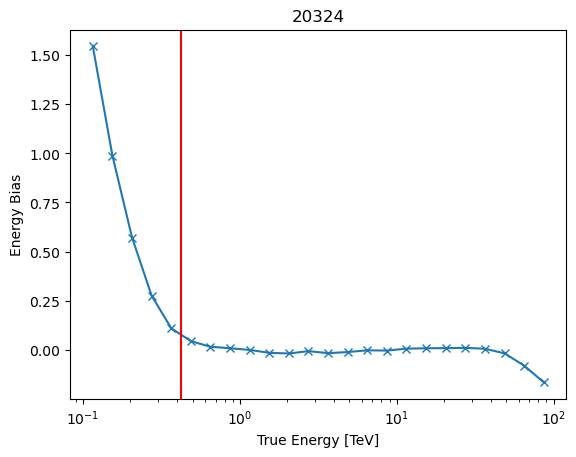

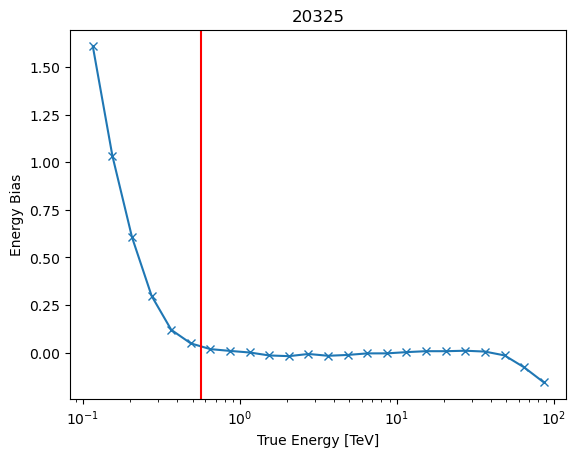

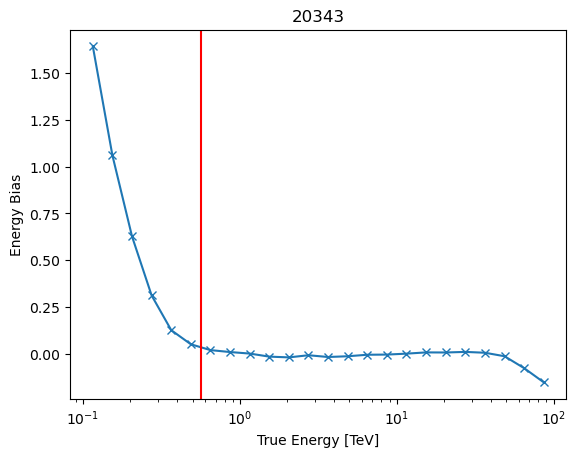

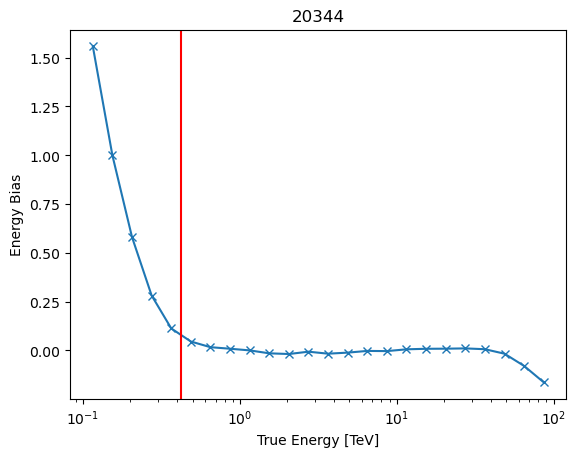

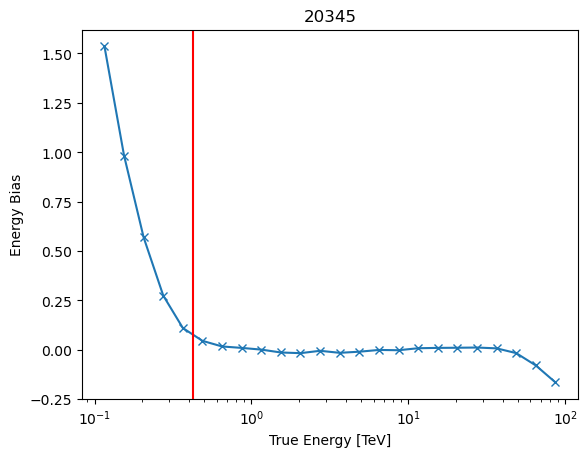

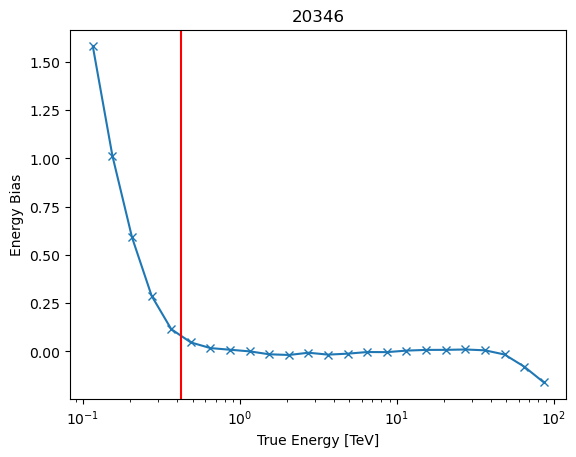

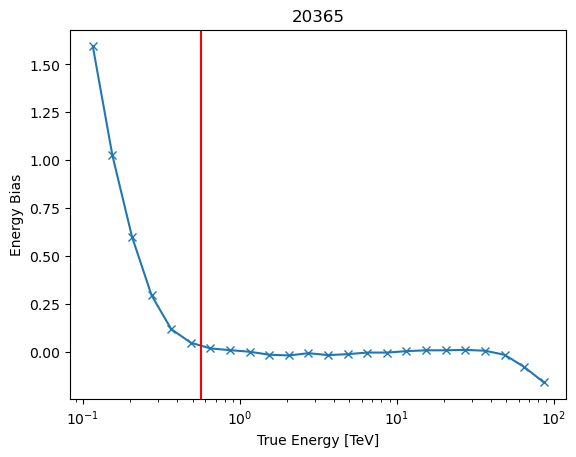

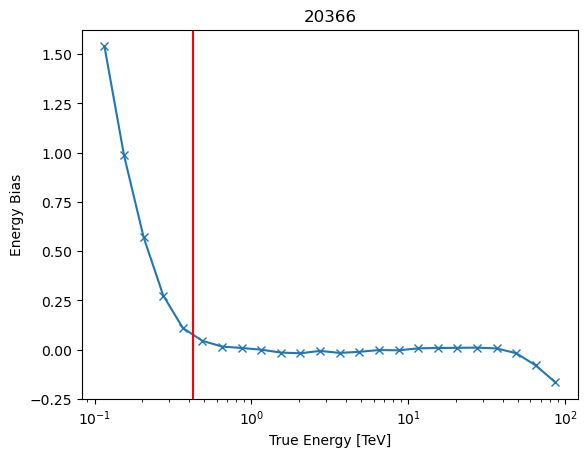

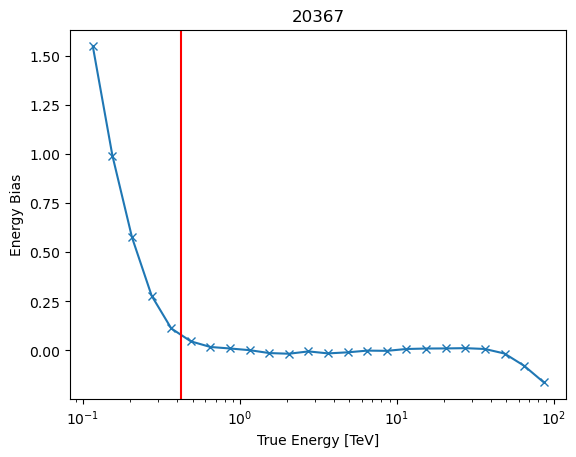

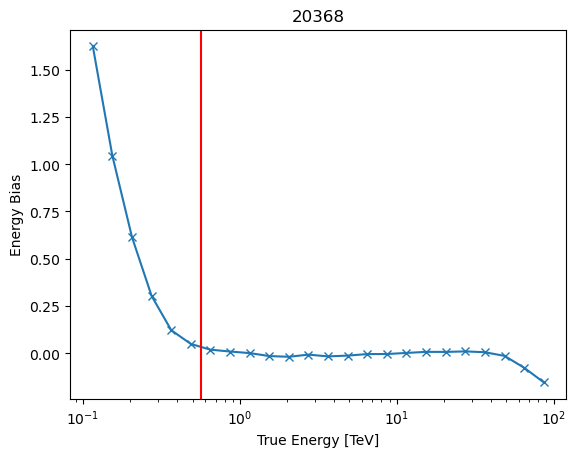

In [9]:

emax=10*units.TeV
# open file to print into
with open(store_threshold, 'w') as f:

    for obs in observations:
        thr_offset = max_offset * units.deg

        # extract energy dispersion for maximum offset
        edisp = obs.edisp.to_edisp_kernel(thr_offset, energy=energy_binning, energy_true=energy_binning)
        e_true = edisp.axes['energy_true'].center
        values = edisp.get_bias(e_true)
        plt.figure()
        # determine threshold from energy dispersion
        threshold = edisp.get_bias_energy(0.1,energy_min=e_true[np.nanargmax(values)],energy_max=emax)[0]
        if e_true[np.nanargmax(values)]>emax:
            threshold = edisp.get_bias_energy(0.1,energy_min=e_true[np.nanargmax(values[0:20])],energy_max=emax)[0]

        # use lower edge of first bin above threshold
        threshold = energy_binning[np.where(~(energy_binning.value[:-1]<threshold.value))[0][0]]

        threshold = np.floor(1e4*threshold)/1e4
        #print to file
        print(obs.obs_id, '  {:.4f}'.format(threshold.value),  file=f)
        print('')

        #if threshold.value>1:
        import matplotlib.pyplot as plt
        plt.plot(e_true,values, 'x-')
        plt.axvline(x=threshold.value,color='r', )
        plt.xscale('log')
        #plt.yscale('log')
        plt.xlabel("True Energy [TeV]")
        plt.ylabel("Energy Bias")
        plt.title(obs.obs_id)
        plt.show()



### 2.2. Background Peak Threshold



/tmp/ipykernel_3905580/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


t  20136


/tmp/ipykernel_3905580/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.4074 TeV
    max rate of 10852.24 1 / TeV in bin 5, upper edge 0.5623 TeV TeV
t  20137


/tmp/ipykernel_3905580/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.4074 TeV
    max rate of 5466.54 1 / TeV in bin 5, upper edge 0.5623 TeV TeV
t  20151


/tmp/ipykernel_3905580/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.4074 TeV
    max rate of 11005.70 1 / TeV in bin 5, upper edge 0.5623 TeV TeV
t  20282


/tmp/ipykernel_3905580/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.4074 TeV
    max rate of 10385.16 1 / TeV in bin 5, upper edge 0.5623 TeV TeV
t  20283


/tmp/ipykernel_3905580/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.3802 TeV
    max rate of 10592.23 1 / TeV in bin 5, upper edge 0.5623 TeV TeV
t  20301


/tmp/ipykernel_3905580/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.4074 TeV
    max rate of 10735.52 1 / TeV in bin 5, upper edge 0.5623 TeV TeV
t  20302


/tmp/ipykernel_3905580/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.3802 TeV
    max rate of 11040.76 1 / TeV in bin 4, upper edge 0.4216 TeV TeV
t  20303
    threshold from aeff fits file is 0.3802 TeV
    max rate of 11041.15 1 / TeV in bin 5, upper edge 0.5623 TeV TeV
t  20322


/tmp/ipykernel_3905580/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'
/tmp/ipykernel_3905580/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation

    threshold from aeff fits file is 0.4074 TeV
    max rate of 11374.25 1 / TeV in bin 5, upper edge 0.5623 TeV TeV
t  20323


/tmp/ipykernel_3905580/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.3802 TeV
    max rate of 11706.28 1 / TeV in bin 4, upper edge 0.4216 TeV TeV
t  20324


/tmp/ipykernel_3905580/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.3802 TeV
    max rate of 11642.48 1 / TeV in bin 4, upper edge 0.4216 TeV TeV
t  20325


/tmp/ipykernel_3905580/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.4074 TeV
    max rate of 11538.59 1 / TeV in bin 5, upper edge 0.5623 TeV TeV
t  20343


/tmp/ipykernel_3905580/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.4074 TeV
    max rate of 11219.74 1 / TeV in bin 5, upper edge 0.5623 TeV TeV
t  20344


/tmp/ipykernel_3905580/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.3802 TeV
    max rate of 11527.88 1 / TeV in bin 5, upper edge 0.5623 TeV TeV
t  20345


/tmp/ipykernel_3905580/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.3802 TeV
    max rate of 11646.33 1 / TeV in bin 4, upper edge 0.4216 TeV TeV
t  20346


/tmp/ipykernel_3905580/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.3802 TeV
    max rate of 11422.09 1 / TeV in bin 5, upper edge 0.5623 TeV TeV
t  20365


/tmp/ipykernel_3905580/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.3802 TeV
    max rate of 10989.49 1 / TeV in bin 5, upper edge 0.5623 TeV TeV
t  20366


/tmp/ipykernel_3905580/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.3802 TeV
    max rate of 10893.00 1 / TeV in bin 4, upper edge 0.4216 TeV TeV
t  20367


/tmp/ipykernel_3905580/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.3802 TeV
    max rate of 10642.33 1 / TeV in bin 5, upper edge 0.5623 TeV TeV
t  20368
    threshold from aeff fits file is 0.4074 TeV
    max rate of 10522.10 1 / TeV in bin 5, upper edge 0.5623 TeV TeV


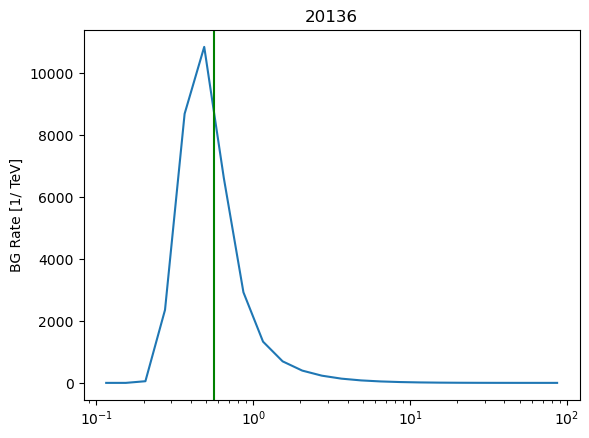

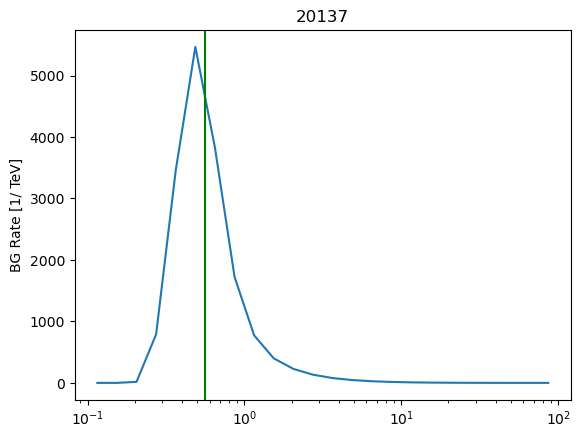

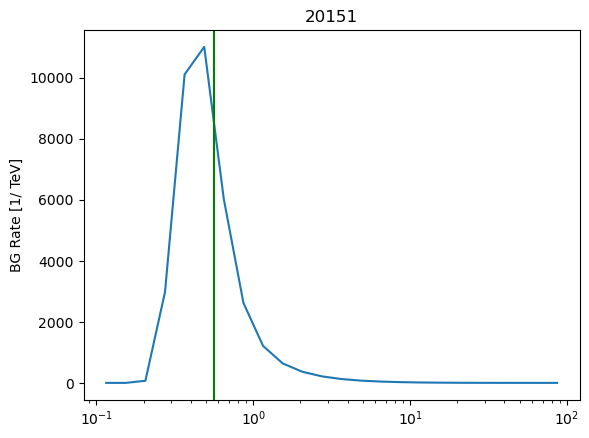

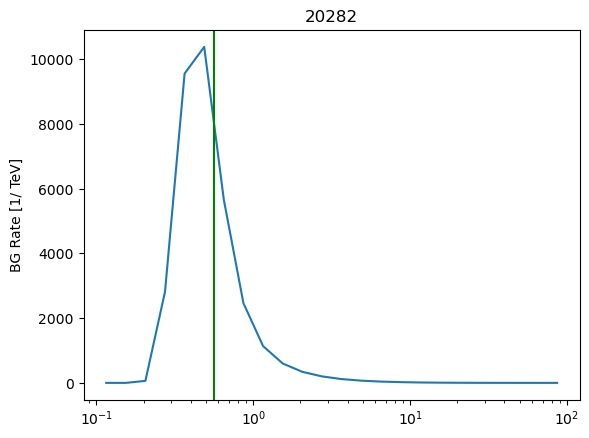

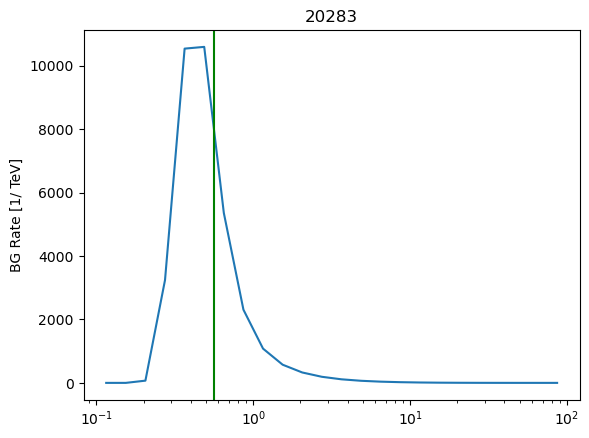

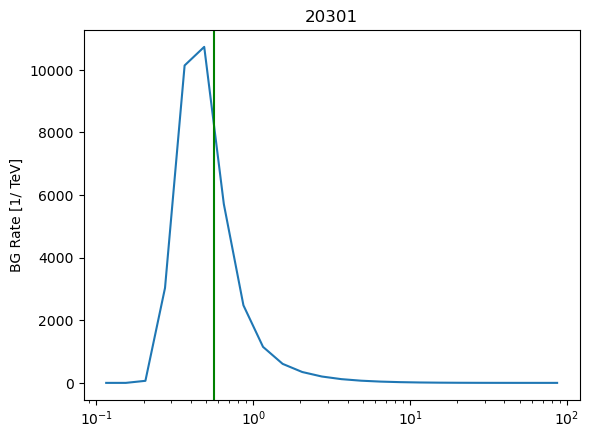

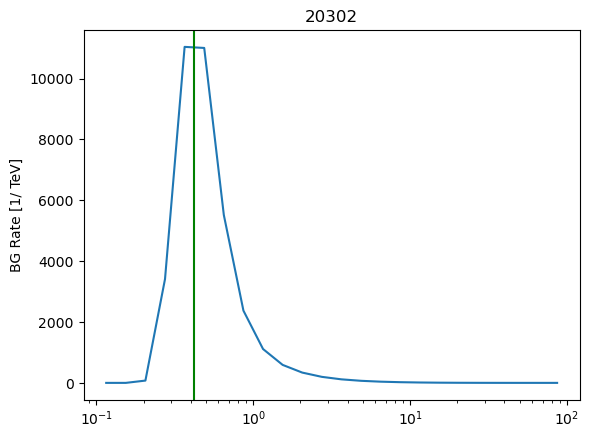

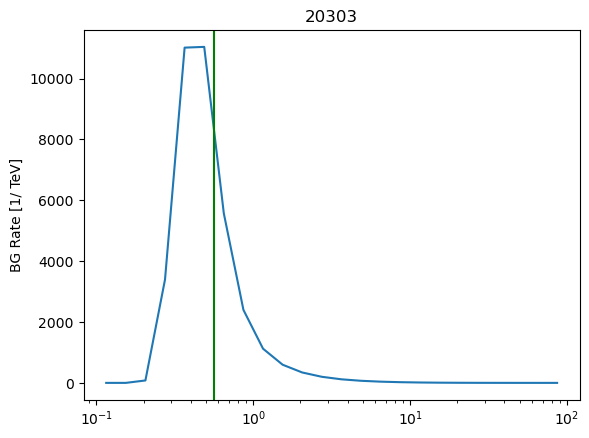

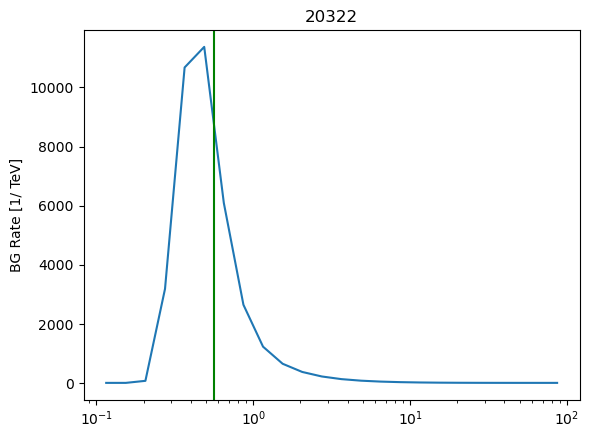

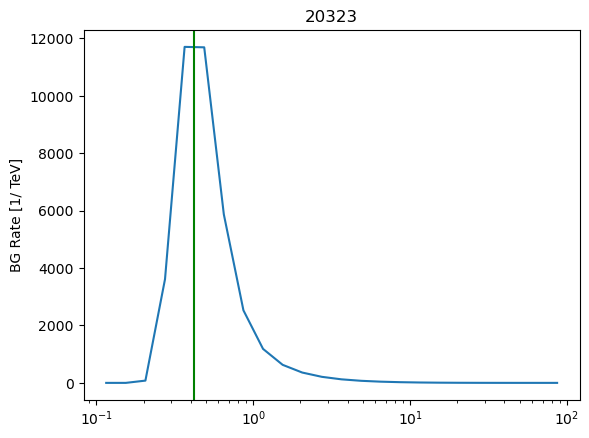

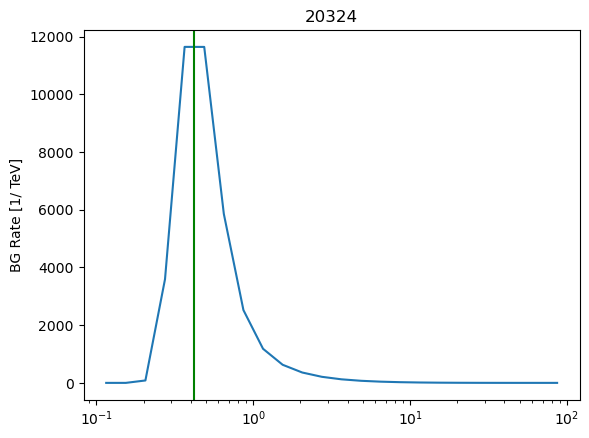

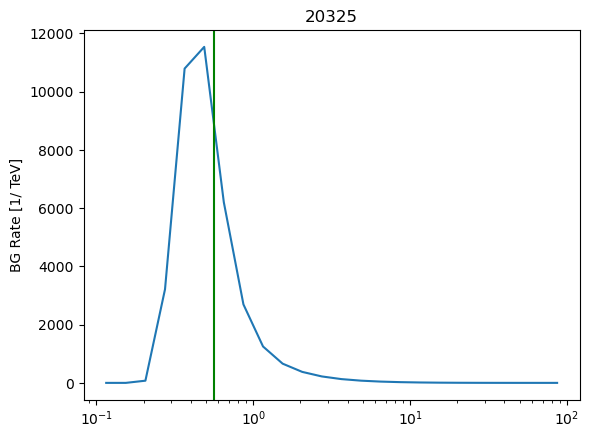

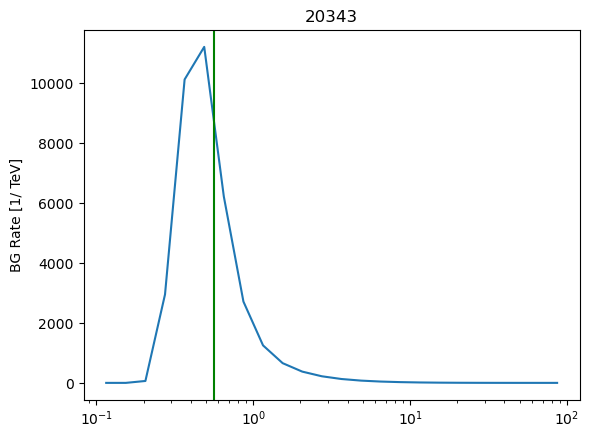

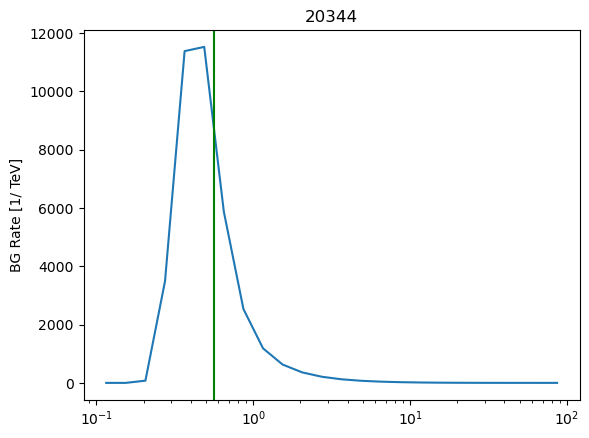

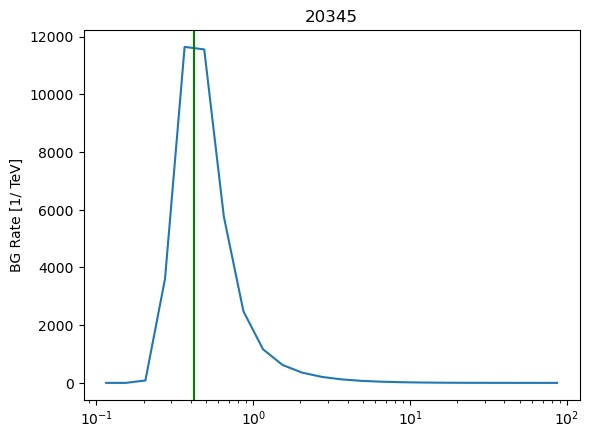

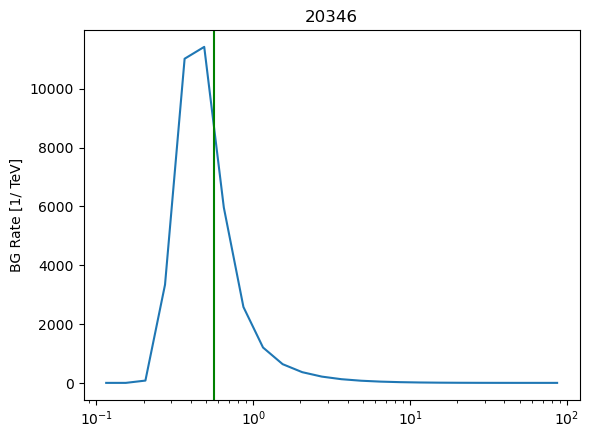

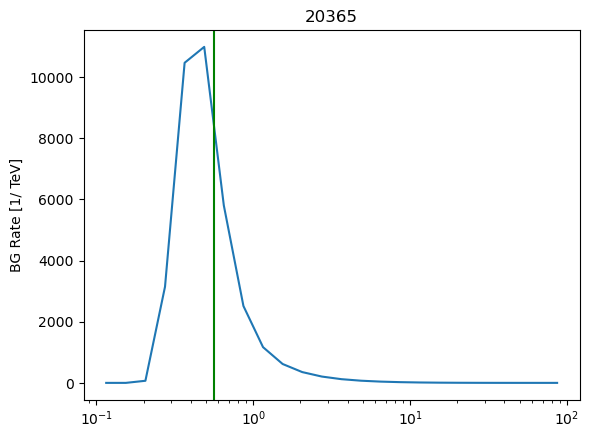

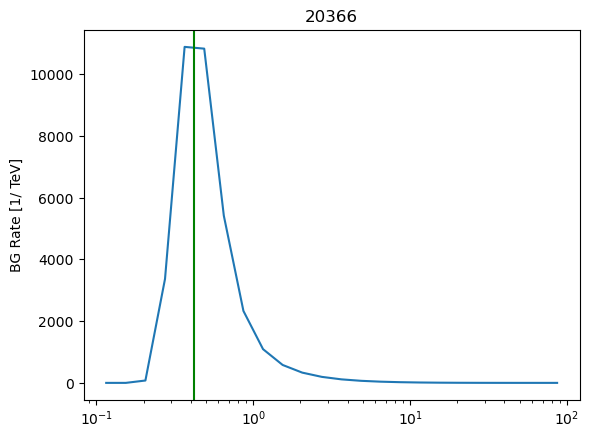

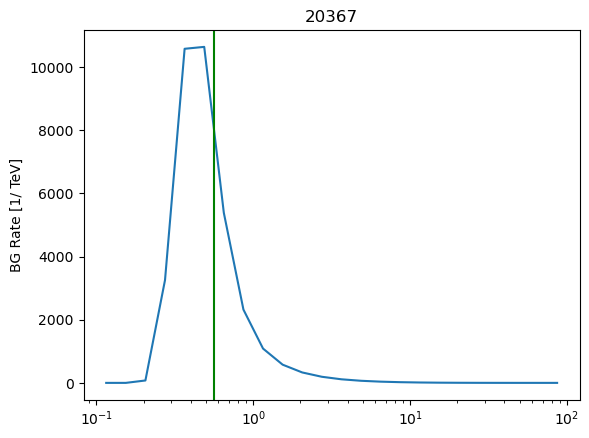

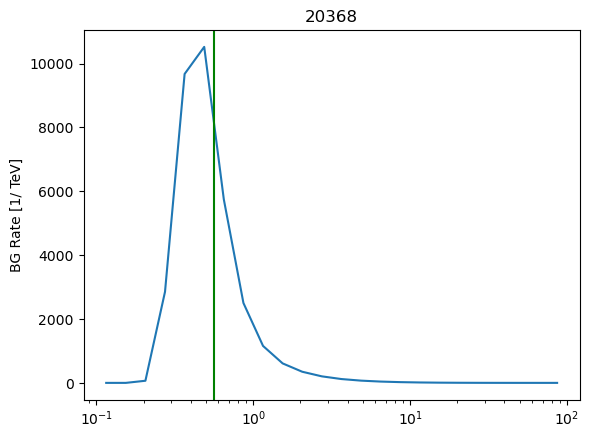

In [10]:

maker = MapDatasetMaker(background_oversampling=2, selection=['background'])
bgmodel_version = 'v08c'


min_energies = {}

# open file to print into
with open(store_bgthreshold, 'w') as f:

    ra_pnt = data_store.obs_table['RA_PNT']
    dec_pnt = data_store.obs_table['DEC_PNT']

    min_energies[source] = OrderedDict()

    for j in range(len(observations)):
        obs = observations[j]
        print('t ', obs.obs_id)
        e_thres = obs.aeff.meta['LO_THRES']
        eaxis = MapAxis.from_edges(get_ebins(), unit='TeV', name='energy', interp='log')

        geom = WcsGeom.create(
            skydir=obs.pointing_radec,
            binsz=0.02,
            width=(4.3, 4.3),
            frame='icrs',
            proj='CAR',
            axes=[eaxis],
        )
        bg_map = maker.make_background(geom, obs)


        bg_rate = bg_map.data.sum(axis=(1,2)) / np.diff(eaxis.edges)
        plt.figure()
        plt.plot(eaxis.center.value, bg_rate)
        plt.ylabel('BG Rate [1/ TeV]')
        plt.xscale('log')
        plt.title(obs.obs_id)
        
        print('    threshold from aeff fits file is {:.4f} TeV'.format(e_thres))
         # print to file
        print(obs.obs_id, '  {:.4f}'.format(e_thres), file=f)
        emin = eaxis.edges[1:][np.argmax(bg_rate)]
        emin = np.floor(1e4*emin)/1e4
        plt.axvline(x=emin.value,color='green', )
        
        print('    max rate of {:.2f} in bin {:d}, upper edge {:.4f} TeV'.format(np.max(bg_rate), np.argmax(bg_rate), emin))
        
        min_energies[source][obs.obs_id] = emin


## Compare Thresholds

In [11]:
thres_list = store_threshold#"threshold.txt"
thresholds = np.loadtxt(thres_list)
bgthres_list = store_bgthreshold#"bkg_threshold.txt"
bgthresholds = np.loadtxt(bgthres_list)
#pick the one with max value
maxthreshold = np.array(list(map(max, zip(thresholds[:,1], bgthresholds[:,1]))))


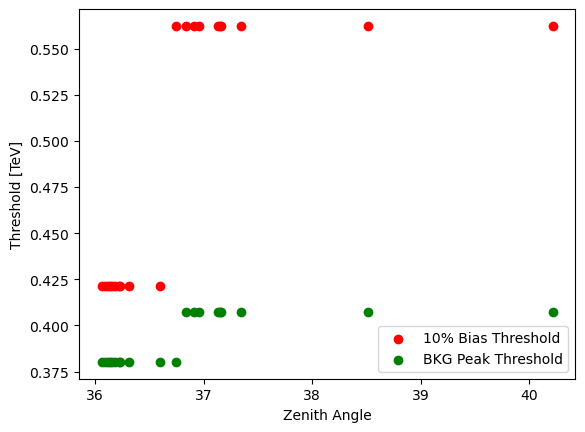

In [12]:
plt.scatter(angle,thresholds[:,1], label  = "10% Bias Threshold", color = 'r')
plt.scatter(angle,bgthresholds[:,1],label  = "BKG Peak Threshold", color = 'green')
plt.legend()
plt.xlabel("Zenith Angle")
plt.ylabel("Threshold [TeV]")
if pks:
    plt.title(f"PKS 2155−304 - flare \n nruns: {len(observations)}")
fig = plt.gcf()
fig.savefig(f"plots/1-thresholds_zenith_{source}.png")

## 3. Run-wise BKG Fitting and Dataset Creation

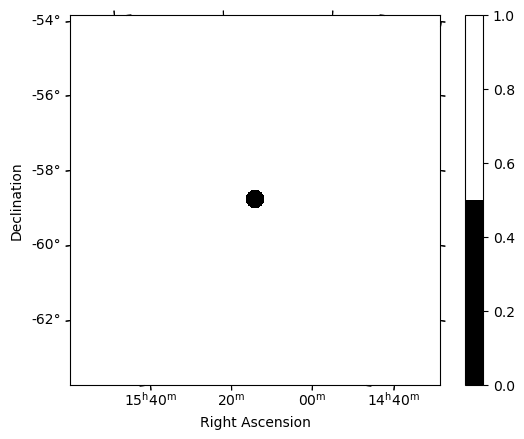

In [13]:
# define exclusion region around the source
excl_regions = []
lon_width,lat_width,pix_size = 10,10,0.02
radius = 0.25*u.deg
skyregion = CircleSkyRegion(center=pks_pos, radius=radius)
excl_regions = [skyregion]
excl_mask_2d = Map.from_geom(get_geom()[1], data=get_geom()[1].region_mask(excl_regions, inside=False).data)
excl_mask_2d.plot(add_cbar = 1, vmin =0, vmax = 1);

0 Observation

	obs id            : 20136 
 	tstart            : 53090.12
	tstop             : 53090.14
	duration          : 1682.00 s
	pointing (icrs)   : 228.6 deg, -58.8 deg

	deadtime fraction : 0.0%



<timed exec>:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : dEFM2r7m 

  Total counts                    : 2703 
  Total background counts         : 2918.93
  Total excess counts             : -215.93

  Predicted counts                : 2702.99
  Predicted background counts     : 2702.99
  Predicted excess counts         : 0.00

  Exposure min                    : 3.67e+06 m2 s
  Exposure max                    : 7.41e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 555838 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 29546.56

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : dEFM2r7m-bkg
    Datasets names            : ['dEFM2r7m']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      0.907   +/-    0.02            

<timed exec>:33: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead


1 Observation

	obs id            : 20137 
 	tstart            : 53090.14
	tstop             : 53090.16
	duration          : 902.00 s
	pointing (icrs)   : 228.6 deg, -59.8 deg

	deadtime fraction : 0.0%



<timed exec>:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : Ho5JLETI 

  Total counts                    : 1655 
  Total background counts         : 1700.64
  Total excess counts             : -45.64

  Predicted counts                : 1654.89
  Predicted background counts     : 1654.89
  Predicted excess counts         : 0.00

  Exposure min                    : 1.31e+07 m2 s
  Exposure max                    : 4.20e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 555827 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 19529.92

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : Ho5JLETI-bkg
    Datasets names            : ['Ho5JLETI']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      0.964   +/-    0.02             

<timed exec>:33: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead


2 Observation

	obs id            : 20151 
 	tstart            : 53091.10
	tstop             : 53091.12
	duration          : 1683.00 s
	pointing (icrs)   : 228.6 deg, -58.8 deg

	deadtime fraction : 0.0%



<timed exec>:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : nZIWkcBs 

  Total counts                    : 2351 
  Total background counts         : 2645.93
  Total excess counts             : -294.93

  Predicted counts                : 2350.97
  Predicted background counts     : 2350.97
  Predicted excess counts         : 0.00

  Exposure min                    : 6.90e+06 m2 s
  Exposure max                    : 7.16e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 555827 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 26053.94

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : nZIWkcBs-bkg
    Datasets names            : ['nZIWkcBs']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      0.884   +/-    0.02            

<timed exec>:33: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead


3 Observation

	obs id            : 20282 
 	tstart            : 53109.98
	tstop             : 53110.00
	duration          : 1687.00 s
	pointing (icrs)   : 228.6 deg, -58.8 deg

	deadtime fraction : 0.0%



<timed exec>:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : PDoYvU5d 

  Total counts                    : 2155 
  Total background counts         : 2492.60
  Total excess counts             : -337.60

  Predicted counts                : 2154.98
  Predicted background counts     : 2154.98
  Predicted excess counts         : 0.00

  Exposure min                    : 6.93e+06 m2 s
  Exposure max                    : 7.21e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 555754 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 24433.37

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : PDoYvU5d-bkg
    Datasets names            : ['PDoYvU5d']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      0.855   +/-    0.02            

<timed exec>:33: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead


4 Observation

	obs id            : 20283 
 	tstart            : 53110.00
	tstop             : 53110.02
	duration          : 1683.00 s
	pointing (icrs)   : 228.6 deg, -59.8 deg

	deadtime fraction : 0.0%



<timed exec>:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : 97rncV2Z 

  Total counts                    : 2522 
  Total background counts         : 3643.82
  Total excess counts             : -1121.82

  Predicted counts                : 2522.07
  Predicted background counts     : 2522.07
  Predicted excess counts         : 0.00

  Exposure min                    : 9.09e+06 m2 s
  Exposure max                    : 7.03e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 586642 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 26835.10

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : 97rncV2Z-bkg
    Datasets names            : ['97rncV2Z']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      0.681   +/-    0.01           

<timed exec>:33: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead


5 Observation

	obs id            : 20301 
 	tstart            : 53110.98
	tstop             : 53111.00
	duration          : 1683.00 s
	pointing (icrs)   : 228.6 deg, -58.8 deg

	deadtime fraction : 0.0%



<timed exec>:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : xByoHime 

  Total counts                    : 2274 
  Total background counts         : 2514.44
  Total excess counts             : -240.44

  Predicted counts                : 2274.00
  Predicted background counts     : 2274.00
  Predicted excess counts         : 0.00

  Exposure min                    : 7.57e+06 m2 s
  Exposure max                    : 7.10e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 555756 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 25472.34

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : xByoHime-bkg
    Datasets names            : ['xByoHime']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      0.896   +/-    0.02            

<timed exec>:33: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead


6 Observation

	obs id            : 20302 
 	tstart            : 53111.00
	tstop             : 53111.02
	duration          : 1682.00 s
	pointing (icrs)   : 228.6 deg, -59.8 deg

	deadtime fraction : 0.0%



<timed exec>:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : Kl6SJSMA 

  Total counts                    : 3947 
  Total background counts         : 3764.49
  Total excess counts             : 182.51

  Predicted counts                : 3946.80
  Predicted background counts     : 3946.80
  Predicted excess counts         : 0.00

  Exposure min                    : 9.26e+06 m2 s
  Exposure max                    : 6.95e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 586658 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 38599.64

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : Kl6SJSMA-bkg
    Datasets names            : ['Kl6SJSMA']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      1.034   +/-    0.02             

<timed exec>:33: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead


7 Observation

	obs id            : 20303 
 	tstart            : 53111.03
	tstop             : 53111.04
	duration          : 1682.00 s
	pointing (icrs)   : 228.6 deg, -58.8 deg

	deadtime fraction : 0.0%



<timed exec>:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : iTWujEiS 

  Total counts                    : 3735 
  Total background counts         : 3785.27
  Total excess counts             : -50.27

  Predicted counts                : 3735.01
  Predicted background counts     : 3735.01
  Predicted excess counts         : 0.00

  Exposure min                    : 9.14e+06 m2 s
  Exposure max                    : 6.97e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 586668 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 36995.65

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : iTWujEiS-bkg
    Datasets names            : ['iTWujEiS']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      0.976   +/-    0.02             

<timed exec>:33: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead


8 Observation

	obs id            : 20322 
 	tstart            : 53111.98
	tstop             : 53112.00
	duration          : 1682.00 s
	pointing (icrs)   : 228.6 deg, -59.8 deg

	deadtime fraction : 0.0%



<timed exec>:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : 1wLmATFd 

  Total counts                    : 2572 
  Total background counts         : 2684.46
  Total excess counts             : -112.46

  Predicted counts                : 2572.02
  Predicted background counts     : 2572.02
  Predicted excess counts         : 0.00

  Exposure min                    : 7.38e+06 m2 s
  Exposure max                    : 7.10e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 555815 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 28358.28

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : 1wLmATFd-bkg
    Datasets names            : ['1wLmATFd']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      0.942   +/-    0.02            

<timed exec>:33: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead


9 Observation

	obs id            : 20323 
 	tstart            : 53112.00
	tstop             : 53112.02
	duration          : 1682.00 s
	pointing (icrs)   : 228.6 deg, -58.8 deg

	deadtime fraction : 0.0%



<timed exec>:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : PL_UWCv_ 

  Total counts                    : 4087 
  Total background counts         : 3999.84
  Total excess counts             : 87.16

  Predicted counts                : 4086.94
  Predicted background counts     : 4086.94
  Predicted excess counts         : 0.00

  Exposure min                    : 9.17e+06 m2 s
  Exposure max                    : 6.93e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 586482 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 40314.55

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : PL_UWCv_-bkg
    Datasets names            : ['PL_UWCv_']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      1.022   +/-    0.02             


<timed exec>:33: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead


10 Observation

	obs id            : 20324 
 	tstart            : 53112.02
	tstop             : 53112.04
	duration          : 1683.00 s
	pointing (icrs)   : 228.6 deg, -59.8 deg

	deadtime fraction : 0.0%



<timed exec>:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : hMKBeXhF 

  Total counts                    : 4168 
  Total background counts         : 3989.18
  Total excess counts             : 178.82

  Predicted counts                : 4168.02
  Predicted background counts     : 4168.02
  Predicted excess counts         : 0.00

  Exposure min                    : 9.16e+06 m2 s
  Exposure max                    : 6.93e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 586633 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 40022.16

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : hMKBeXhF-bkg
    Datasets names            : ['hMKBeXhF']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      1.025   +/-    0.02             

<timed exec>:33: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead


11 Observation

	obs id            : 20325 
 	tstart            : 53112.04
	tstop             : 53112.06
	duration          : 1682.00 s
	pointing (icrs)   : 228.6 deg, -58.8 deg

	deadtime fraction : 0.0%



<timed exec>:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : A8bc26HY 

  Total counts                    : 2546 
  Total background counts         : 2726.53
  Total excess counts             : -180.53

  Predicted counts                : 2546.00
  Predicted background counts     : 2546.00
  Predicted excess counts         : 0.00

  Exposure min                    : 7.37e+06 m2 s
  Exposure max                    : 7.11e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 555753 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 28219.32

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : A8bc26HY-bkg
    Datasets names            : ['A8bc26HY']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      0.907   +/-    0.02            

<timed exec>:33: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead


12 Observation

	obs id            : 20343 
 	tstart            : 53112.97
	tstop             : 53112.99
	duration          : 1682.00 s
	pointing (icrs)   : 228.6 deg, -58.8 deg

	deadtime fraction : 0.0%



<timed exec>:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : g2vbilGP 

  Total counts                    : 2428 
  Total background counts         : 2741.11
  Total excess counts             : -313.11

  Predicted counts                : 2428.00
  Predicted background counts     : 2428.00
  Predicted excess counts         : 0.00

  Exposure min                    : 6.38e+06 m2 s
  Exposure max                    : 7.19e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 555712 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 26950.59

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : g2vbilGP-bkg
    Datasets names            : ['g2vbilGP']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      0.872   +/-    0.02            

<timed exec>:33: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead


13 Observation

	obs id            : 20344 
 	tstart            : 53112.99
	tstop             : 53113.01
	duration          : 1682.00 s
	pointing (icrs)   : 228.6 deg, -59.8 deg

	deadtime fraction : 0.0%



<timed exec>:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : nSaqI1P4 

  Total counts                    : 4374 
  Total background counts         : 3986.09
  Total excess counts             : 387.91

  Predicted counts                : 4373.68
  Predicted background counts     : 4373.68
  Predicted excess counts         : 0.00

  Exposure min                    : 8.76e+06 m2 s
  Exposure max                    : 6.97e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 586748 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 41796.70

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : nSaqI1P4-bkg
    Datasets names            : ['nSaqI1P4']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      1.081   +/-    0.02             

<timed exec>:33: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead


14 Observation

	obs id            : 20345 
 	tstart            : 53113.01
	tstop             : 53113.03
	duration          : 1683.00 s
	pointing (icrs)   : 228.6 deg, -58.8 deg

	deadtime fraction : 0.0%



<timed exec>:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : O_MEApEo 

  Total counts                    : 3897 
  Total background counts         : 3936.20
  Total excess counts             : -39.20

  Predicted counts                : 3897.00
  Predicted background counts     : 3897.00
  Predicted excess counts         : 0.00

  Exposure min                    : 9.38e+06 m2 s
  Exposure max                    : 6.92e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 586700 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 38378.24

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : O_MEApEo-bkg
    Datasets names            : ['O_MEApEo']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      0.981   +/-    0.02             

<timed exec>:33: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead


15 Observation

	obs id            : 20346 
 	tstart            : 53113.03
	tstop             : 53113.05
	duration          : 1683.00 s
	pointing (icrs)   : 228.6 deg, -59.8 deg

	deadtime fraction : 0.0%



<timed exec>:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : DA764S5z 

  Total counts                    : 4334 
  Total background counts         : 4008.78
  Total excess counts             : 325.22

  Predicted counts                : 4333.95
  Predicted background counts     : 4333.95
  Predicted excess counts         : 0.00

  Exposure min                    : 8.19e+06 m2 s
  Exposure max                    : 7.03e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 586712 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 41483.11

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : DA764S5z-bkg
    Datasets names            : ['DA764S5z']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      1.061   +/-    0.02             

<timed exec>:33: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead


16 Observation

	obs id            : 20365 
 	tstart            : 53113.98
	tstop             : 53114.00
	duration          : 1683.00 s
	pointing (icrs)   : 228.6 deg, -59.8 deg

	deadtime fraction : 0.0%



<timed exec>:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : tWshJkpw 

  Total counts                    : 2374 
  Total background counts         : 2557.01
  Total excess counts             : -183.01

  Predicted counts                : 2374.00
  Predicted background counts     : 2374.00
  Predicted excess counts         : 0.00

  Exposure min                    : 7.84e+06 m2 s
  Exposure max                    : 7.12e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 555843 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 26357.25

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : tWshJkpw-bkg
    Datasets names            : ['tWshJkpw']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      0.922   +/-    0.02            

<timed exec>:33: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead


17 Observation

	obs id            : 20366 
 	tstart            : 53114.00
	tstop             : 53114.02
	duration          : 1683.00 s
	pointing (icrs)   : 228.6 deg, -58.8 deg

	deadtime fraction : 0.0%



<timed exec>:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : GvEr83EB 

  Total counts                    : 3541 
  Total background counts         : 3697.22
  Total excess counts             : -156.22

  Predicted counts                : 3540.98
  Predicted background counts     : 3540.98
  Predicted excess counts         : 0.00

  Exposure min                    : 9.35e+06 m2 s
  Exposure max                    : 6.97e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 586662 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 35838.52

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : GvEr83EB-bkg
    Datasets names            : ['GvEr83EB']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      0.957   +/-    0.02            

<timed exec>:33: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead


18 Observation

	obs id            : 20367 
 	tstart            : 53114.02
	tstop             : 53114.04
	duration          : 1682.00 s
	pointing (icrs)   : 228.6 deg, -59.8 deg

	deadtime fraction : 0.0%



<timed exec>:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : QCosgLmj 

  Total counts                    : 3651 
  Total background counts         : 3661.04
  Total excess counts             : -10.04

  Predicted counts                : 3650.96
  Predicted background counts     : 3650.96
  Predicted excess counts         : 0.00

  Exposure min                    : 9.10e+06 m2 s
  Exposure max                    : 7.02e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 586728 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 36226.55

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : QCosgLmj-bkg
    Datasets names            : ['QCosgLmj']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      0.984   +/-    0.02             

<timed exec>:33: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead


19 Observation

	obs id            : 20368 
 	tstart            : 53114.04
	tstop             : 53114.06
	duration          : 1683.00 s
	pointing (icrs)   : 228.6 deg, -58.8 deg

	deadtime fraction : 0.0%



<timed exec>:14: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : rR-NFHo6 

  Total counts                    : 2099 
  Total background counts         : 2526.49
  Total excess counts             : -427.49

  Predicted counts                : 2099.05
  Predicted background counts     : 2099.05
  Predicted excess counts         : 0.00

  Exposure min                    : 6.98e+06 m2 s
  Exposure max                    : 7.21e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 555827 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 23629.88

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : rR-NFHo6-bkg
    Datasets names            : ['rR-NFHo6']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                          :      0.832   +/-    0.02            

<timed exec>:33: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead


CPU times: user 4min 41s, sys: 1min, total: 5min 41s
Wall time: 5min 40s


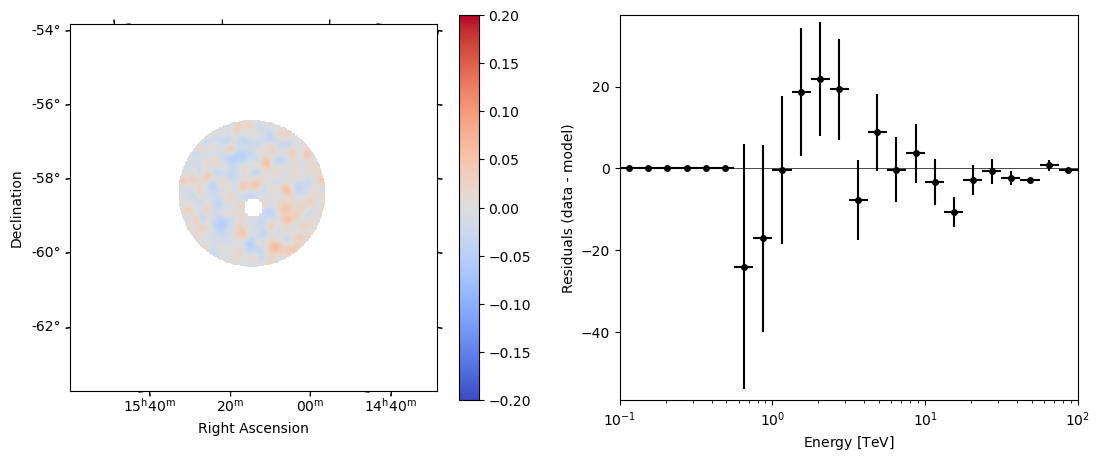

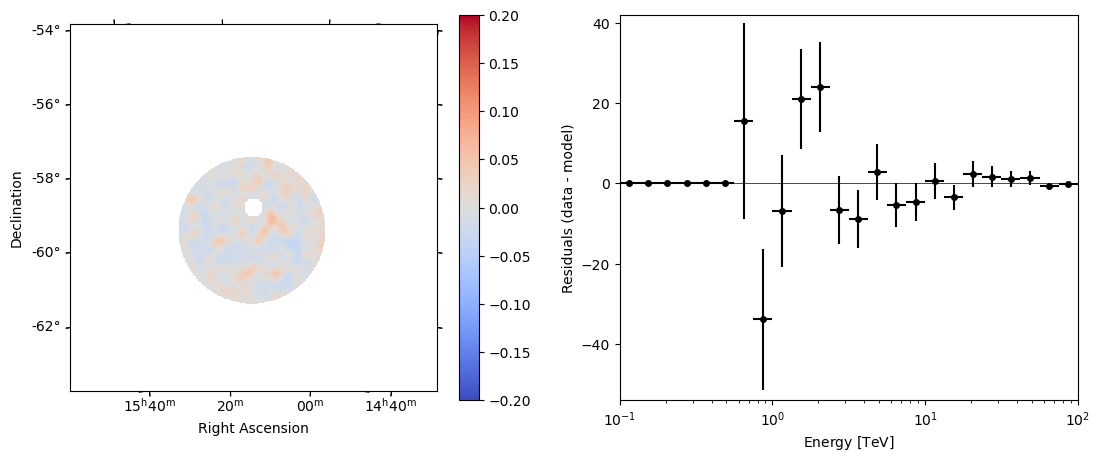

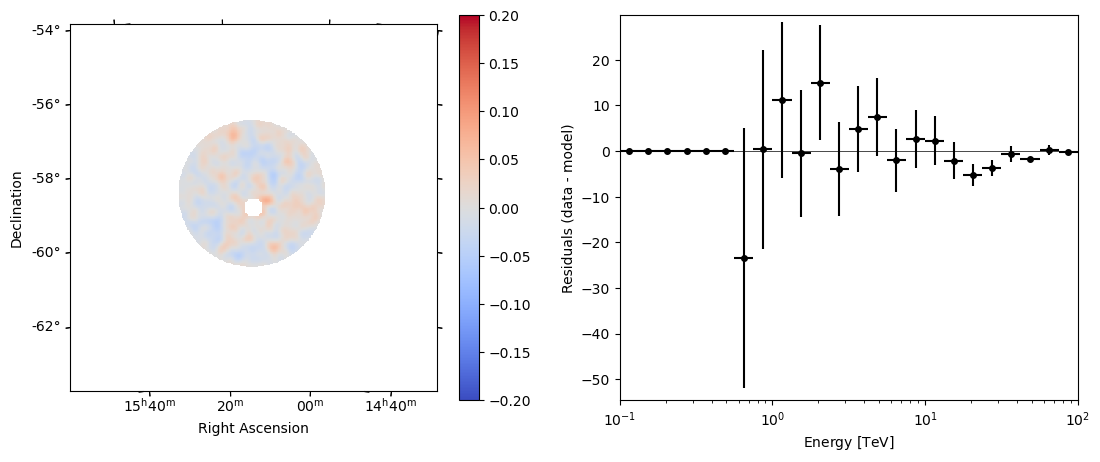

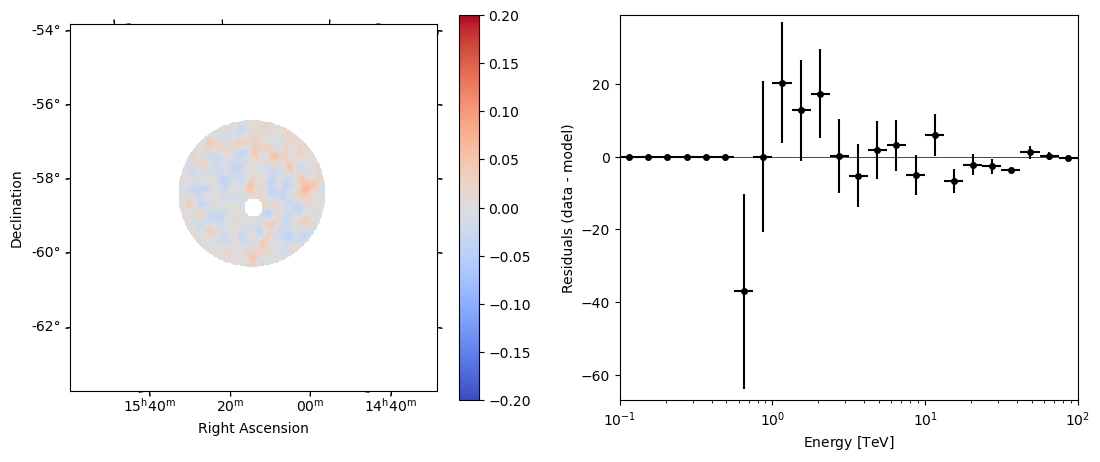

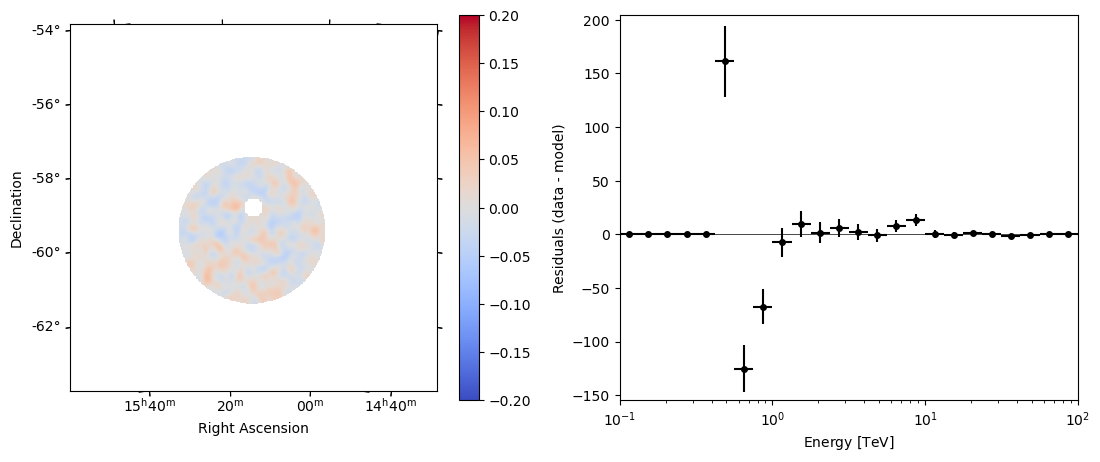

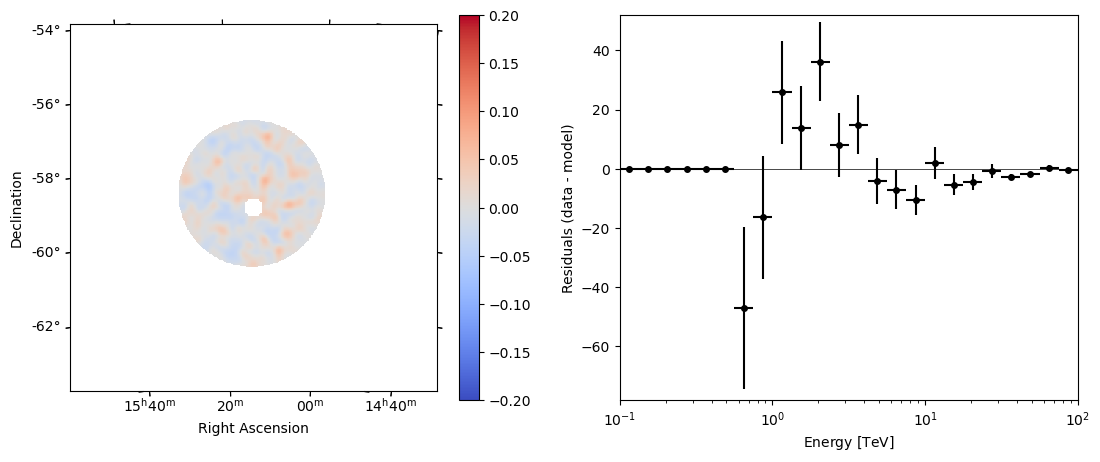

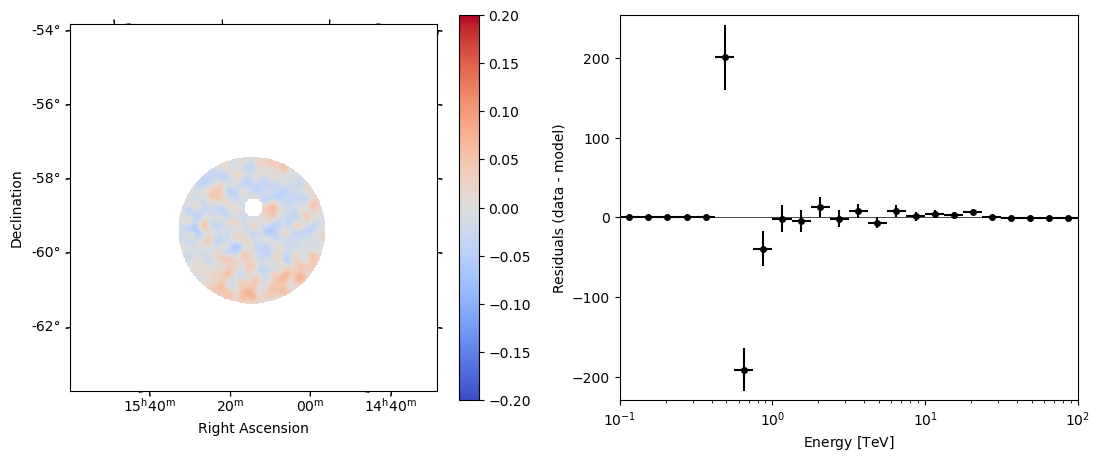

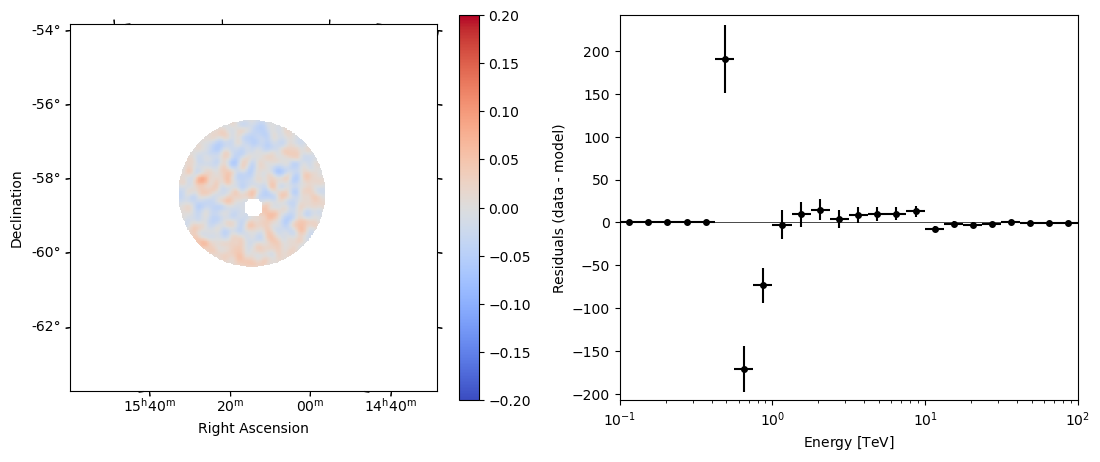

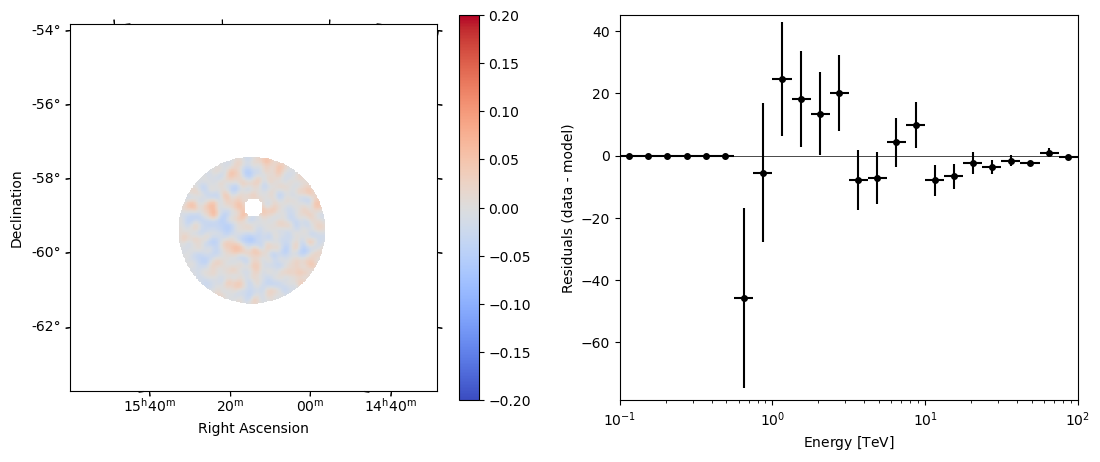

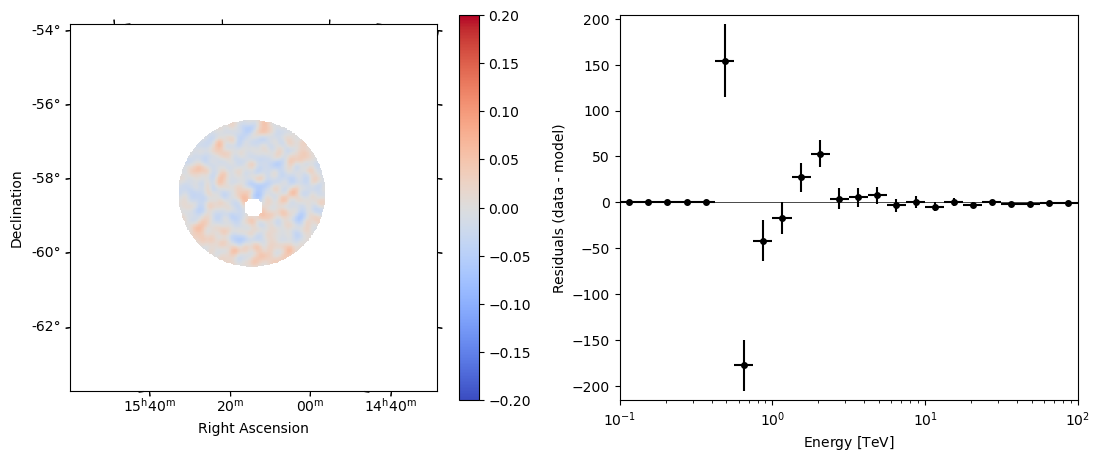

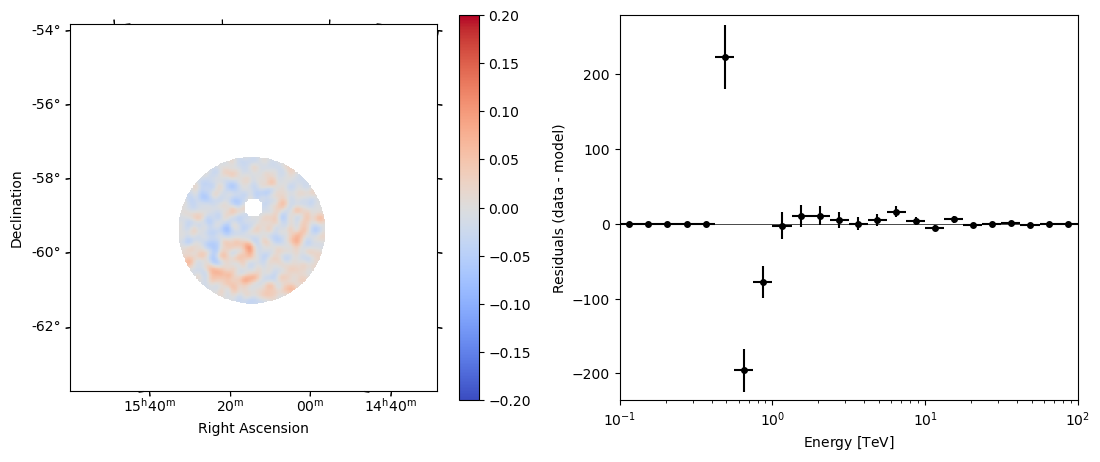

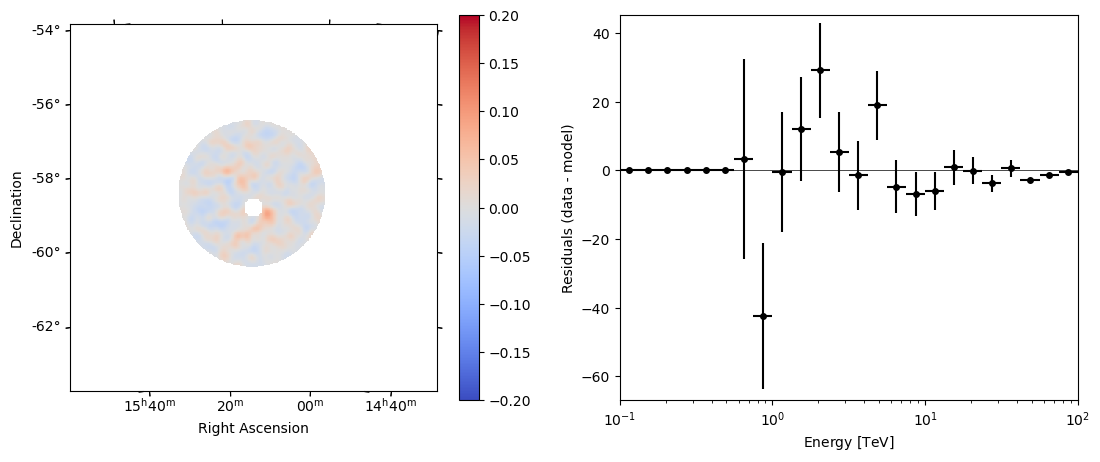

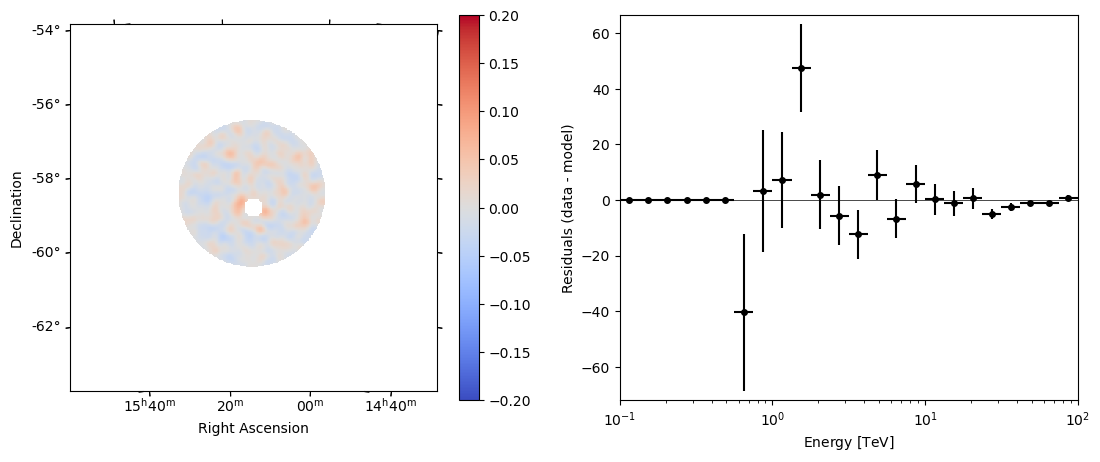

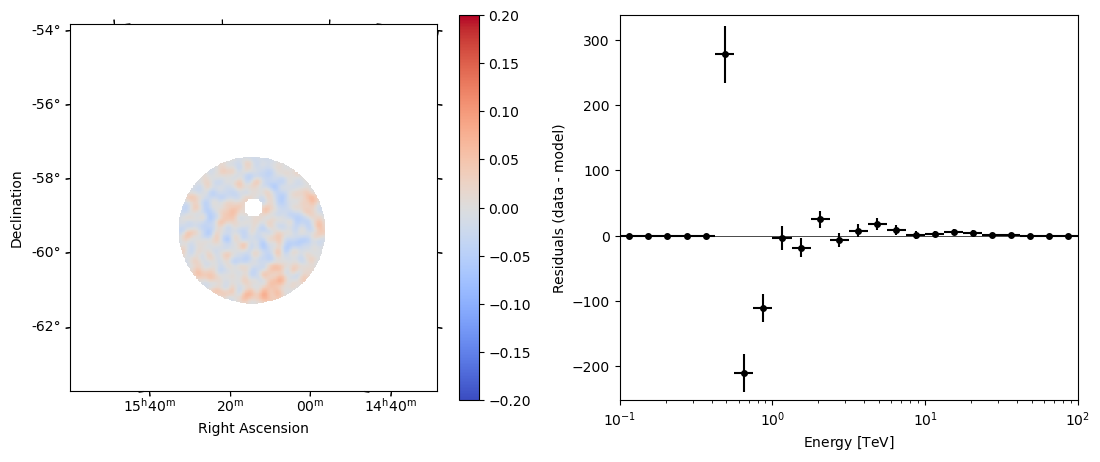

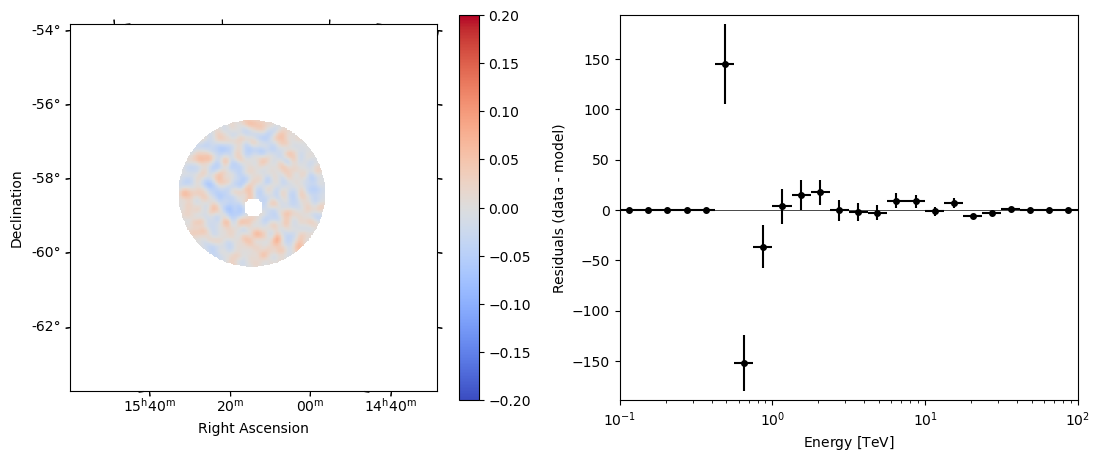

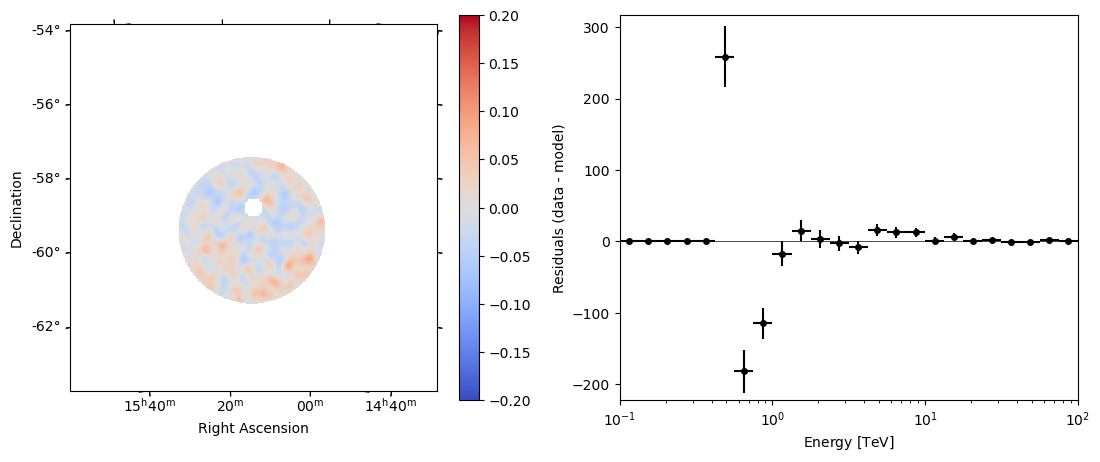

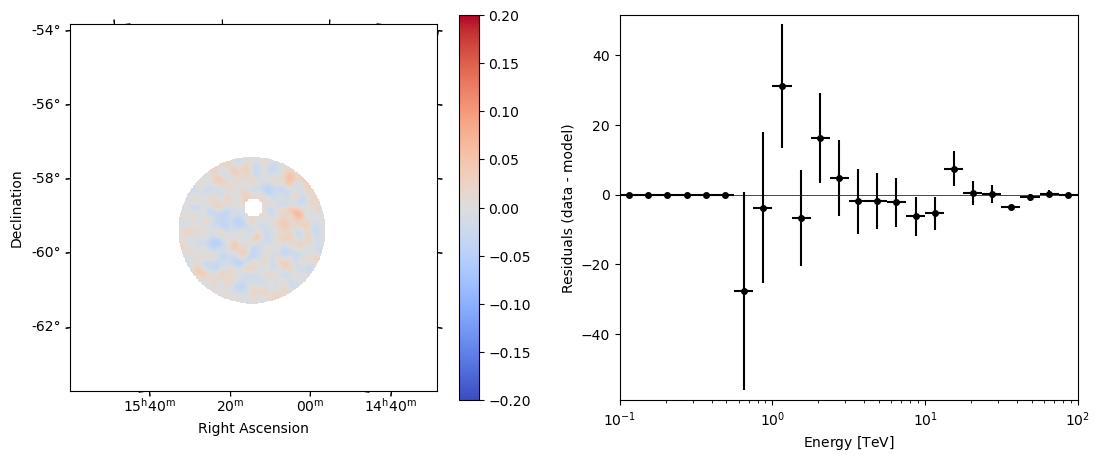

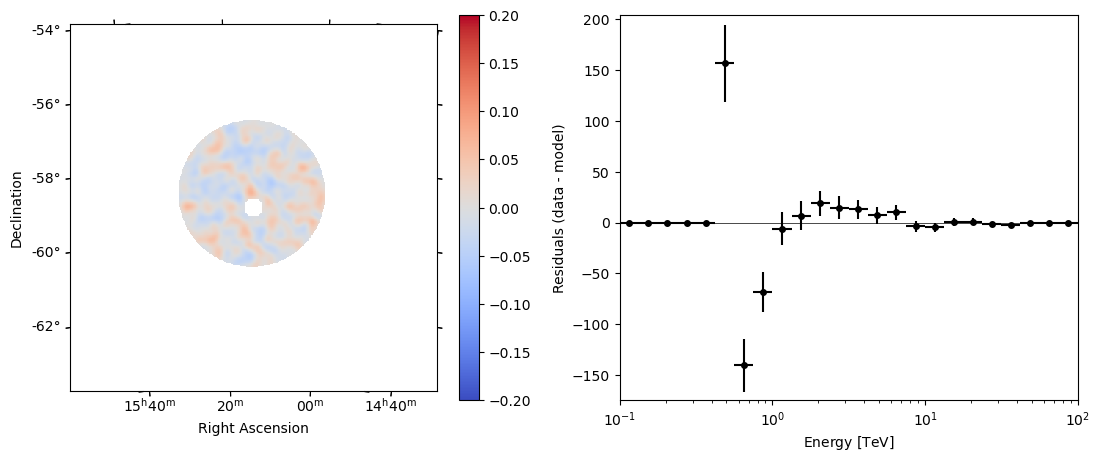

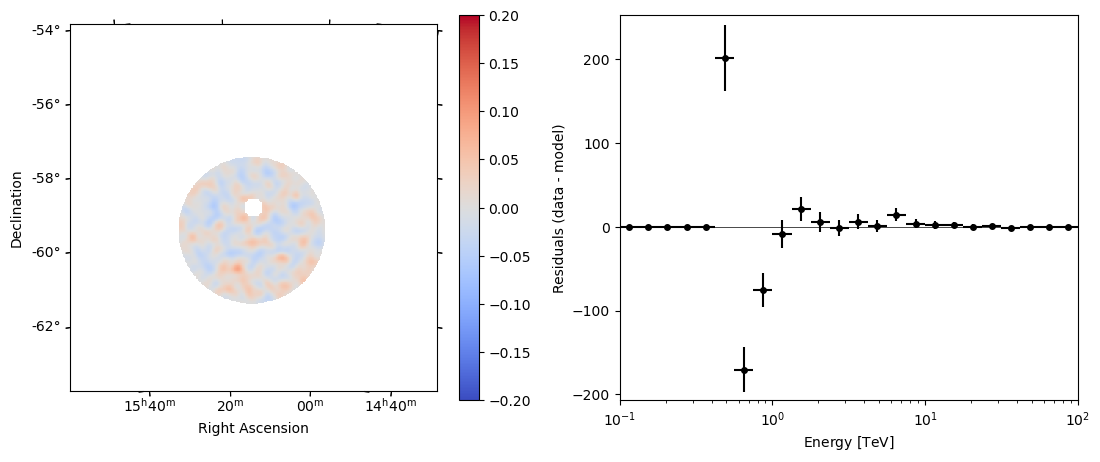

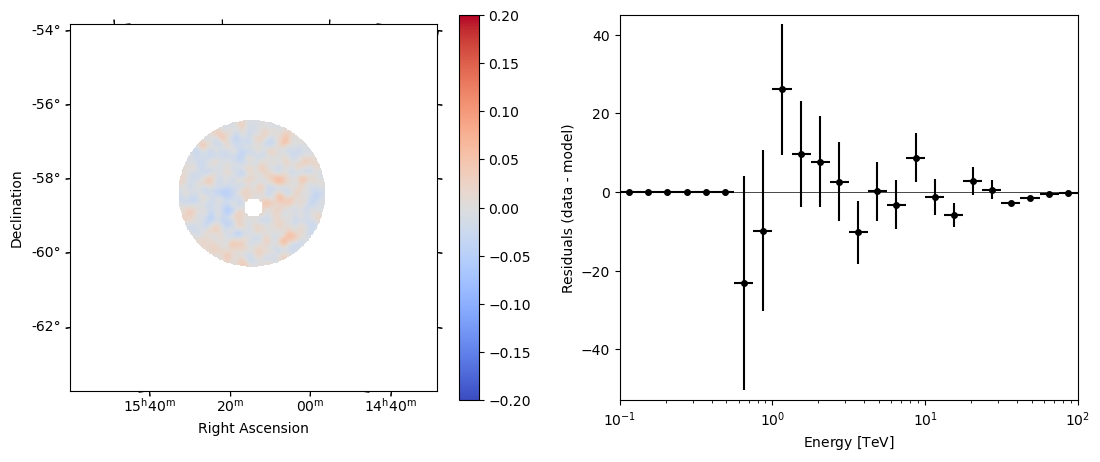

In [14]:
%%time
max_offset = 2*u.deg
geom = get_geom()[0]

maker = MapDatasetMaker(background_oversampling=2)
maker_safe_mask = SafeMaskMaker(methods=['offset-max'], offset_max=max_offset)
dataset_stacked = MapDataset.create(geom=geom, name='stacked')

bg_norms_  , bg_tilts_ = [], []

for i,obs in enumerate(observations):
    print(i, obs)
    plt.figure(figsize = (13,5))
    
    reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)    
    dataset = maker.run(reference, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    
    bkg_model = FoVBackgroundModel(dataset_name="{}".format(dataset.name))
    models = Models([bkg_model])
    dataset.models = models
    dataset.background_model.spectral_model.tilt.frozen = False

    dataset.mask_safe.data[:] &= excl_mask_2d.data
    ebins = get_ebins()
    emask = ebins[:-1].value >= maxthreshold[i]
    
    dataset.mask_safe.data[~emask,:,:] = False
    fit = Fit(optimize_opts={"print_level": 1})
    result = fit.run(datasets=[dataset])
    print(dataset)
    ax = dataset.plot_residuals(kwargs_spatial = {'vmax': 0.2, 'vmin': -0.2})
    mask_obs_max_offset = geom.to_image().region_mask(
        [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
    )
    dataset.mask_safe.data[emask] = dataset.mask_safe.data[emask] | mask_obs_max_offset

    assert np.isfinite(dataset.background.data[dataset.mask_safe.data]).all()
    dataset.background.data[~dataset.mask_safe.data] = 0.0

    dataset_stacked.stack(dataset)
    # save all datasets
    if pks:
        dataset.write('{}/dataset-obs-{}.fits.gz'.format(path_saving,obs.obs_id), overwrite=True)
    if msh:
        dataset.write('{}/dataset-msh-obs-{}.fits.gz'.format(path_saving,obs.obs_id), overwrite=True)
        
    bg_norms, bg_tilts = np.array(dataset.background_model.parameters.value[:2])
    bg_norms_.append(dataset.background_model.parameters['norm'].value)
    bg_tilts_.append(dataset.background_model.parameters['tilt'].value)
    
if pks:
    dataset_stacked.write('{}/dataset-stacked.fits.gz'.format(path_saving), overwrite=True)
if msh:
    dataset_stacked.write('{}/dataset-msh-stacked.fits.gz'.format(path_saving), overwrite=True)
    

## Best Fit Results
The BKG normm should be distributed around 1, and the tilt around 0.

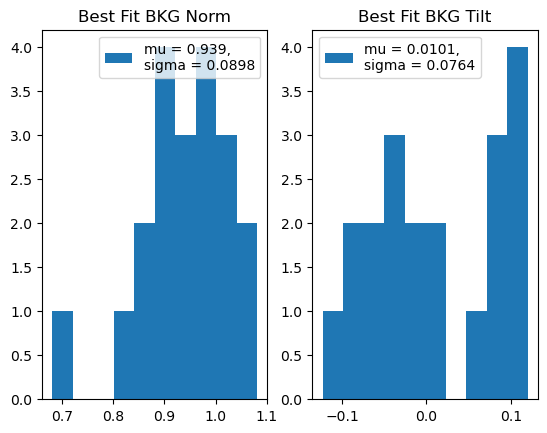

In [15]:
fig,axs = plt.subplots(1,2)
axs[0].hist(bg_norms_, label = f"mu = {np.mean(bg_norms_):.3}, \nsigma = {np.std(bg_norms_):.3}")
axs[1].hist(bg_tilts_, label = f"mu = {np.mean(bg_tilts_):.3}, \nsigma = {np.std(bg_tilts_):.3}")
axs[0].legend();axs[1].legend();
axs[0].set_title("Best Fit BKG Norm")
axs[1].set_title("Best Fit BKG Tilt")

if msh:
    fig.savefig("plots/1-best_fit-bkg-msh.png")
if pks:
    fig.savefig("plots/1-best_fit-bkg.png")
    

<WCSAxes: >

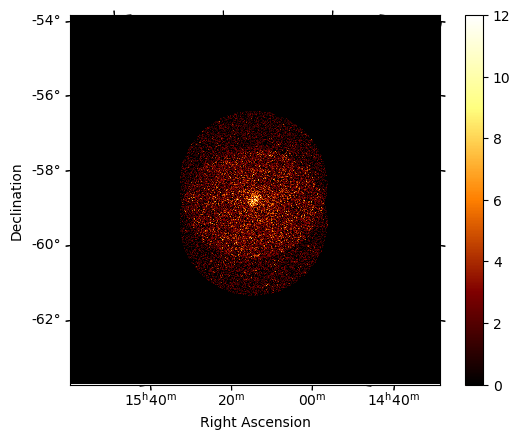

In [16]:
dataset_stacked.counts.sum_over_axes().plot(add_cbar = 1)

(<WCSAxes: >,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals (data - model)'>)

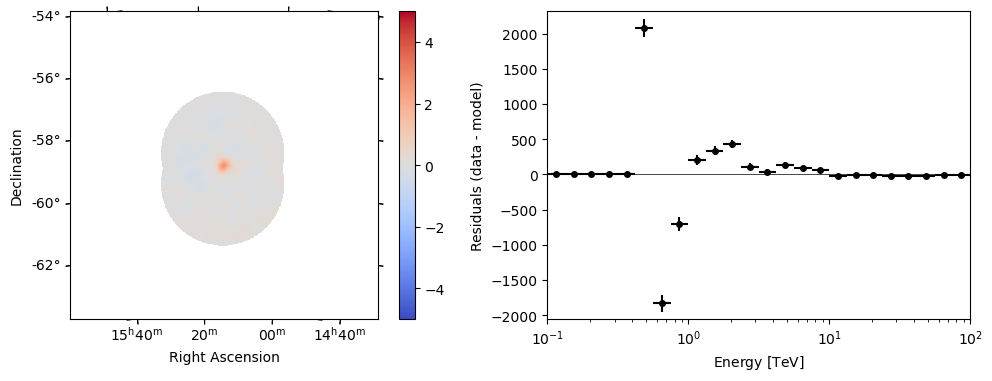

In [18]:
dataset_stacked.plot_residuals()

[]

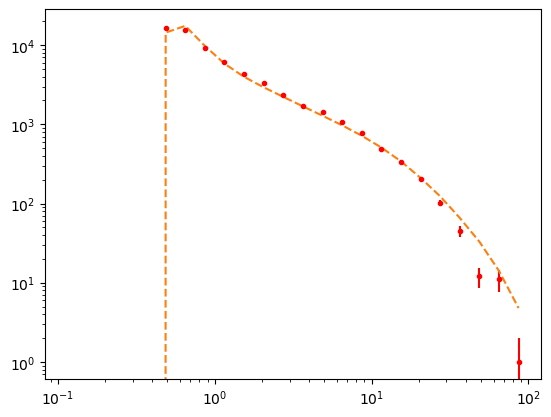

In [21]:
fig, ax = plt.subplots(1,1)
energy = dataset_stacked._geom.axes[0].center.value
ax.errorbar(energy, dataset_stacked.counts.get_spectrum().data.flatten(),
       yerr = np.sqrt(dataset_stacked.counts.get_spectrum().data.flatten()),
           fmt = '.', color = 'red')
ax.plot(energy, dataset_stacked.npred_background().get_spectrum().data.flatten(),
        color = 'tab:orange', linestyle = 'dashed'
       )
ax.loglog()